In [1]:
#| hide
import sys
sys.path.append("/notebooks/katlas")
from nbdev.showdoc import *
%matplotlib inline
%load_ext autoreload
%autoreload 2

In [2]:
from fastbook import *
from katlas.core import Data
from katlas.train import *
from katlas.plot import *
from sklearn.model_selection import StratifiedGroupKFold

/usr/local/lib/python3.9/dist-packages/umap/distances.py:1063: NumbaDeprecationWarning: The 'nopython' keyword argument was not supplied to the 'numba.jit' decorator. The implicit default value for this argument is currently False, but it will be changed to True in Numba 0.59.0. See https://numba.readthedocs.io/en/stable/reference/deprecation.html#deprecation-of-object-mode-fall-back-behaviour-when-using-jit for details.
  @numba.jit()
/usr/local/lib/python3.9/dist-packages/umap/distances.py:1071: NumbaDeprecationWarning: The 'nopython' keyword argument was not supplied to the 'numba.jit' decorator. The implicit default value for this argument is currently False, but it will be changed to True in Numba 0.59.0. See https://numba.readthedocs.io/en/stable/reference/deprecation.html#deprecation-of-object-mode-fall-back-behaviour-when-using-jit for details.
  @numba.jit()
/usr/local/lib/python3.9/dist-packages/umap/distances.py:1086: NumbaDeprecationWarning: The 'nopython' keyword argument 

# Train ML model

> a collection of tools to train various ML model

In this file, we will show you how to train ML model using the features we extracted

## Prepare training file

amino acid

In [3]:
aa = Data.get_aa_feature()

In [ ]:
aa.shape

(23, 73)

In [ ]:
# reduce dimension
aa_pca = reduce_dim(aa,n_components=5)

# add annotation
aa_pca.columns = 'aa_' + aa_pca.columns

aa_pca = aa_pca.rename(columns = {'aa_aa':'aa'})

protein

In [ ]:
prot = Data.get_esm_pca32()

In [ ]:
prot.shape

(298, 33)

In [ ]:
# prot = pd.read_csv('t5_umap32.csv')

In [ ]:
# add annotation
prot2 = prot.set_index('kinase')

prot2.columns = 'kinase_' + prot2.columns

prot = prot2.reset_index()

target with position info

In [ ]:
target = Data.get_standard_unstack()

In [ ]:
target.head()

kinase substrate    target  position aa
0    AAK1       -5P  0.203681        -5  P
1  ACVR2A       -5P -0.497906        -5  P
2  ACVR2B       -5P -0.274530        -5  P
3    AKT1       -5P -0.138624        -5  P
4    AKT2       -5P -0.052269        -5  P

In [ ]:
target = Data.get_log_unstack()

In [ ]:
target.head()

kinase substrate     target  position aa
0    AAK1       -5P  15.845517        -5  P
1  ACVR2A       -5P  15.423155        -5  P
2  ACVR2B       -5P  17.091913        -5  P
3    AKT1       -5P  16.727835        -5  P
4    AKT2       -5P  15.509150        -5  P

In [ ]:
target = target.query('kinase != "CK1G2" ').reset_index(drop=True)

In [ ]:
df = target.merge(prot,'left').merge(aa_pca,'left')

In [ ]:
df.head(2)

kinase substrate     target  position aa      PCA1      PCA2      PCA3  \
0   AAK1       -5P  15.845517        -5  P -0.529323 -0.529422 -0.277885   
1   AAK1       -4P  15.475701        -4  P -0.529323 -0.529422 -0.277885   

       PCA4      PCA5      PCA6      PCA7      PCA8     PCA9     PCA10  \
0  0.427082 -0.191013 -0.206378  0.036362  0.283639 -0.03368 -0.345977   
1  0.427082 -0.191013 -0.206378  0.036362  0.283639 -0.03368 -0.345977   

      PCA11    PCA12     PCA13     PCA14     PCA15     PCA16     PCA17  \
0 -0.320672  0.19172  0.164984  0.105528 -0.102076  0.177409 -0.065808   
1 -0.320672  0.19172  0.164984  0.105528 -0.102076  0.177409 -0.065808   

      PCA18     PCA19     PCA20     PCA21     PCA22     PCA23     PCA24  \
0 -0.324508 -0.186942 -0.154722  0.108451 -0.048535  0.059394 -0.144194   
1 -0.324508 -0.186942 -0.154722  0.108451 -0.048535  0.059394 -0.144194   

      PCA25     PCA26     PCA27     PCA28     PCA29    PCA30     PCA31  \
0 -0.068808 -0.030775 -0.177793 -0.132509  0.038955  0.09075 -0.128941   
1 -0.068808 -0.030775 -0.177793 -0.132509  0.038955  0.09075 -0.128941   

      PCA32   aa_PCA1   aa_PCA2   aa_PCA3   aa_PCA4   aa_PCA5  
0 -0.116763 -4.604141  2.659866  1.697217 -0.613948  1.642941  
1 -0.116763 -4.604141  2.659866  1.697217 -0.613948  1.642941

## Dummies

We can also use dummies of both aa and kinase as control

In [ ]:
target = Data.get_standard_unstack()

In [ ]:
target = Data.get_log_unstack()

In [ ]:
target.shape

(59994, 5)

In [ ]:
target = target.query('kinase != "CK1G2" ').reset_index(drop=True)

In [ ]:
target.shape

(59796, 5)

In [ ]:
# Get dummies
aa_one = pd.get_dummies(target.aa)

In [ ]:

kinase_one = pd.get_dummies(target.kinase)

In [ ]:
kinase_one.shape

(59796, 302)

In [ ]:
df = pd.concat([target,aa_one],axis=1)

In [ ]:
df = target.merge(aa_pca, 'left')

In [ ]:
df.shape

(59796, 10)

In [ ]:
df = pd.concat([df,kinase_one],axis=1)

## Trainer

### ML models

We can use various ML models to train:
- Xgboost
- LightGBM
- Tablet
- Traditional ML: Regression, others

### XGB

In [ ]:
show_doc(xgb_trainer)

---

### xgb_trainer

>      xgb_trainer (df, feature_col, target_col, test_index=None,
>                   xgb_params={'max_depth': 7, 'learning_rate': 0.001,
>                   'subsample': 0.8, 'colsample_bytree': 1, 'eval_metric':
>                   'rmse', 'objective': 'reg:squarederror', 'tree_method':
>                   'gpu_hist', 'predictor': 'gpu_predictor', 'random_state':
>                   123}, model_file='xgb_model.bin', split_seed=123)

|    | **Type** | **Default** | **Details** |
| -- | -------- | ----------- | ----------- |
| df |  |  |  |
| feature_col |  |  |  |
| target_col |  |  |  |
| test_index | NoneType | None |  |
| xgb_params | dict | {'max_depth': 7, 'learning_rate': 0.001, 'subsample': 0.8, 'colsample_bytree': 1, 'eval_metric': 'rmse', 'objective': 'reg:squarederror', 'tree_method': 'gpu_hist', 'predictor': 'gpu_predictor', 'random_state': 123} |  |
| model_file | str | xgb_model.bin |  |
| split_seed | int | 123 | seed of random split |

Specify the feature column and target column

In [ ]:
df.columns

Index(['kinase', 'substrate', 'target', 'position', 'aa', 'aa', 'aa_PCA1',
       'aa_PCA2', 'aa_PCA3', 'aa_PCA4',
       ...
       'VRK1', 'VRK2', 'WNK1', 'WNK3', 'WNK4', 'YANK2', 'YANK3', 'YSK1',
       'YSK4', 'ZAK'],
      dtype='object', length=314)

In [ ]:
feat_col = ['position'] + df.columns[5:].tolist()

In [ ]:
feat_col

['position',
 'aa_PCA1',
 'aa_PCA2',
 'aa_PCA3',
 'aa_PCA4',
 'aa_PCA5',
 'AAK1',
 'ACVR2A',
 'ACVR2B',
 'AKT1',
 'AKT2',
 'AKT3',
 'ALK2',
 'ALK4',
 'ALPHAK3',
 'AMPKA1',
 'AMPKA2',
 'ANKRD3',
 'ASK1',
 'ATM',
 'ATR',
 'AURA',
 'AURB',
 'AURC',
 'BCKDK',
 'BIKE',
 'BMPR1A',
 'BMPR1B',
 'BMPR2',
 'BRAF',
 'BRSK1',
 'BRSK2',
 'BUB1',
 'CAMK1A',
 'CAMK1B',
 'CAMK1D',
 'CAMK1G',
 'CAMK2A',
 'CAMK2B',
 'CAMK2D',
 'CAMK2G',
 'CAMK4',
 'CAMKK1',
 'CAMKK2',
 'CAMLCK',
 'CDC7',
 'CDK1',
 'CDK10',
 'CDK12',
 'CDK13',
 'CDK14',
 'CDK16',
 'CDK17',
 'CDK18',
 'CDK19',
 'CDK2',
 'CDK3',
 'CDK4',
 'CDK5',
 'CDK6',
 'CDK7',
 'CDK8',
 'CDK9',
 'CDKL1',
 'CDKL5',
 'CHAK1',
 'CHAK2',
 'CHK1',
 'CHK2',
 'CK1A',
 'CK1A2',
 'CK1D',
 'CK1E',
 'CK1G1',
 'CK1G3',
 'CK2A1',
 'CK2A2',
 'CLK1',
 'CLK2',
 'CLK3',
 'CLK4',
 'COT',
 'CRIK',
 'DAPK1',
 'DAPK2',
 'DAPK3',
 'DCAMKL1',
 'DCAMKL2',
 'DLK',
 'DMPK1',
 'DNAPK',
 'DRAK1',
 'DSTYK',
 'DYRK1A',
 'DYRK1B',
 'DYRK2',
 'DYRK3',
 'DYRK4',
 'EEF2K',
 'ERK1',
 'E

In [ ]:
target_col = 'target'

If test_index is not specified, then it will randomly choose some samples as test set

In [ ]:
from scipy.stats import pearsonr

In [ ]:
pred_df, aaaa

In [ ]:
# pearsonr(pred_df.label,pred_df.pred)

# pearsonr(back.label,back.pred)

# pearsonr(back.label,back.pred)

# back.plot.scatter(x='label',y='pred')



# back.plot.scatter(x='label',y='pred')

# back = np.exp(pred_df)

# back = np.exp(pred_df)

# pred_df

xgb params is: {'max_depth': 7, 'learning_rate': 0.001, 'subsample': 0.8, 'colsample_bytree': 1, 'eval_metric': 'rmse', 'objective': 'reg:squarederror', 'tree_method': 'gpu_hist', 'predictor': 'gpu_predictor', 'random_state': 123}
(47995, 326) (47995,) (11999, 326) (11999,)
Int64Index([21415, 52252, 40130, 46523, 53724, 46690, 51338, 51705, 15233,
            22673,
            ...
            54124, 31808, 42022, 18420, 37774, 26583, 56968,  2079, 44226,
             3146],
           dtype='int64', length=11999)
[0]	train-rmse:1.10892	valid-rmse:1.13098
[100]	train-rmse:1.07478	valid-rmse:1.09907
[200]	train-rmse:1.04580	valid-rmse:1.07233
[300]	train-rmse:1.02119	valid-rmse:1.04993
[400]	train-rmse:1.00036	valid-rmse:1.03122
[500]	train-rmse:0.98272	valid-rmse:1.01560
[600]	train-rmse:0.96778	valid-rmse:1.00255
[700]	train-rmse:0.95510	valid-rmse:0.99168
[800]	train-rmse:0.94430	valid-rmse:0.98263
[900]	train-rmse:0.93501	valid-rmse:0.97502
[1000]	train-rmse:0.92704	valid-rmse:0.968

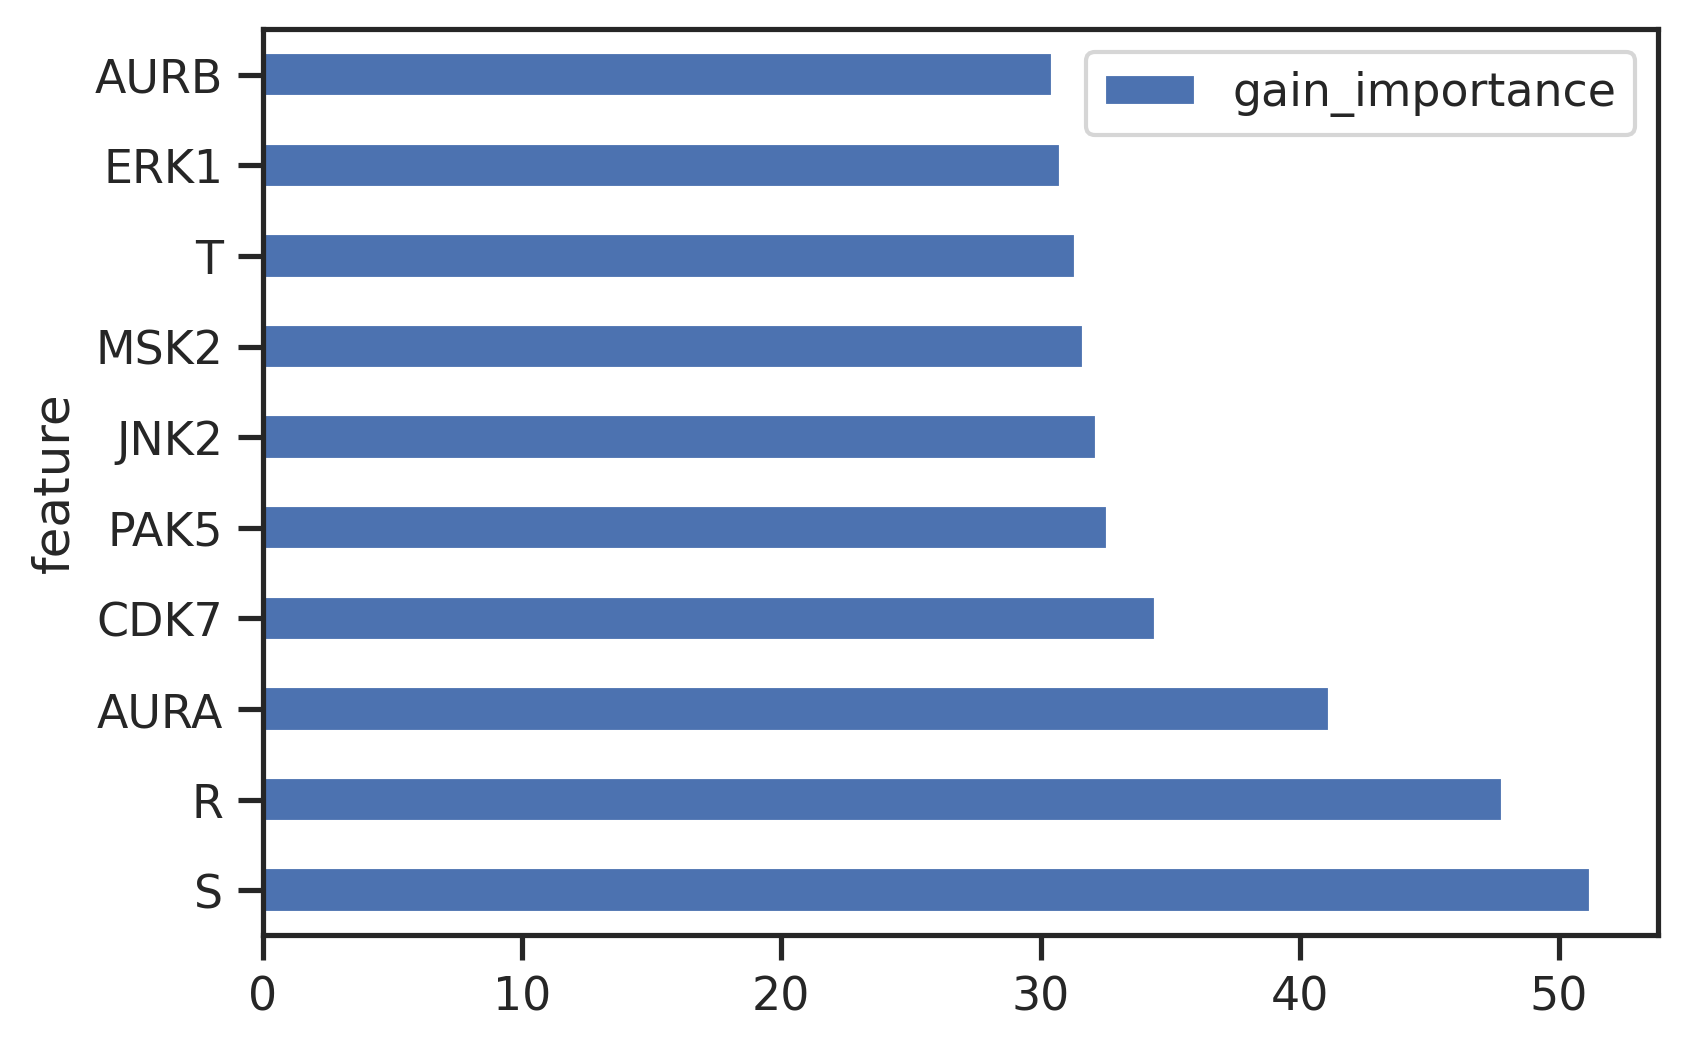

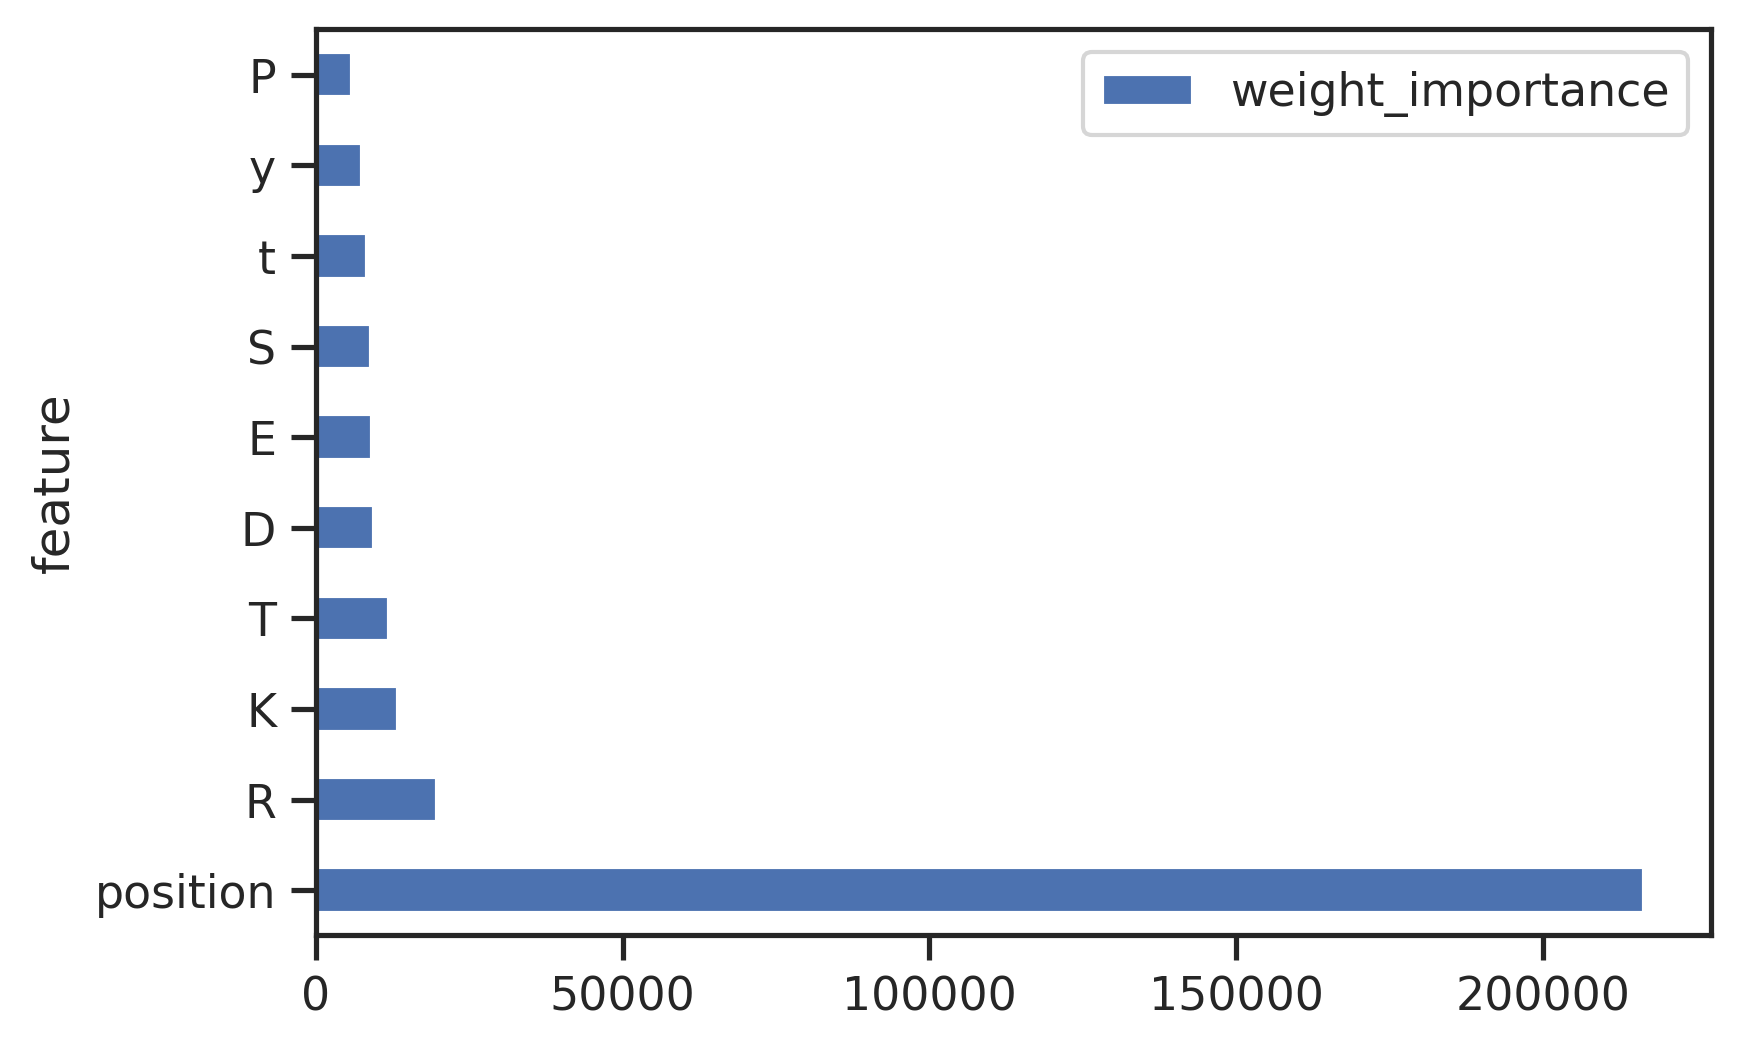

In [ ]:
pred, gain, weight = xgb_trainer(df, feat_col, target_col,model_file = 'model/dummy.bin')

### Split method: StratifiedGroupKfold

We will use StratifiedGroupKFold to split the training and valid set: we group each point by kinase, and then stratify the kinase by their category. This split method ensures that the model can see different patterns of substrate specificity

In [ ]:
# prepare the dataframe for split
kinase_info = Data.get_kinase_info()

kinase_info = kinase_info[['kinase','Family','category','category_big']]

df2 = df[['kinase']].merge(kinase_info,'left')

*c* argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with *x* & *y*.  Please use the *color* keyword-argument or provide a 2D array with a single row if you intend to specify the same RGB or RGBA value for all points.


<AxesSubplot:xlabel='label', ylabel='pred'>

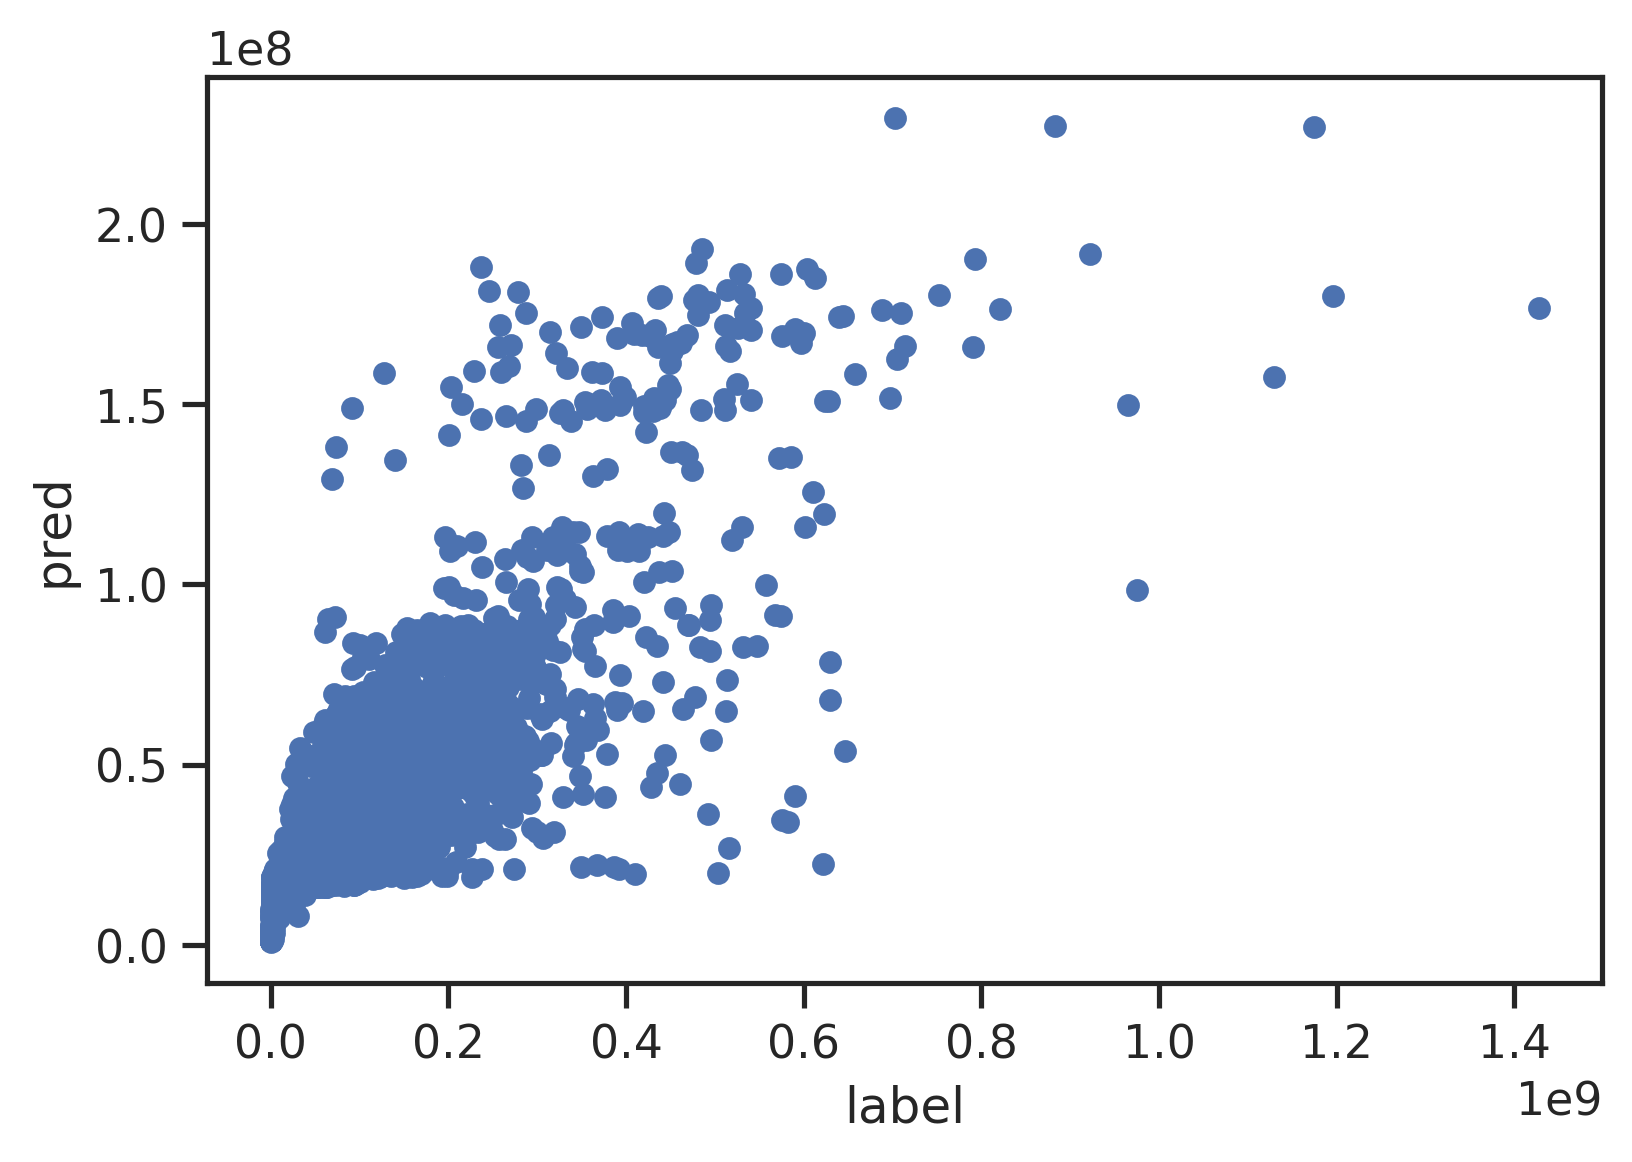

In [ ]:
np.exp(pred_df).plot.scatter('label','pred')

xgb params is: {'max_depth': 7, 'learning_rate': 0.001, 'subsample': 0.8, 'colsample_bytree': 1, 'eval_metric': 'rmse', 'objective': 'reg:squarederror', 'tree_method': 'gpu_hist', 'predictor': 'gpu_predictor', 'random_state': 123}
(47718, 308) (47718,) (12078, 308) (12078,)
Int64Index([    0,     1,     2,     3,     4,     5,     6,     7,     8,
                9,
            ...
            59390, 59391, 59392, 59393, 59394, 59395, 59396, 59397, 59398,
            59399],
           dtype='int64', length=12078)
[0]	train-rmse:16.32159	valid-rmse:16.34461
[100]	train-rmse:14.77744	valid-rmse:14.80050
[200]	train-rmse:13.38118	valid-rmse:13.40417
[300]	train-rmse:12.11885	valid-rmse:12.14175
[400]	train-rmse:10.97792	valid-rmse:11.00065
[500]	train-rmse:9.94678	valid-rmse:9.96936
[600]	train-rmse:9.01507	valid-rmse:9.03747
[700]	train-rmse:8.17357	valid-rmse:8.19580
[800]	train-rmse:7.41369	valid-rmse:7.43574
[900]	train-rmse:6.72774	valid-rmse:6.74959
[1000]	train-rmse:6.10892	valid-

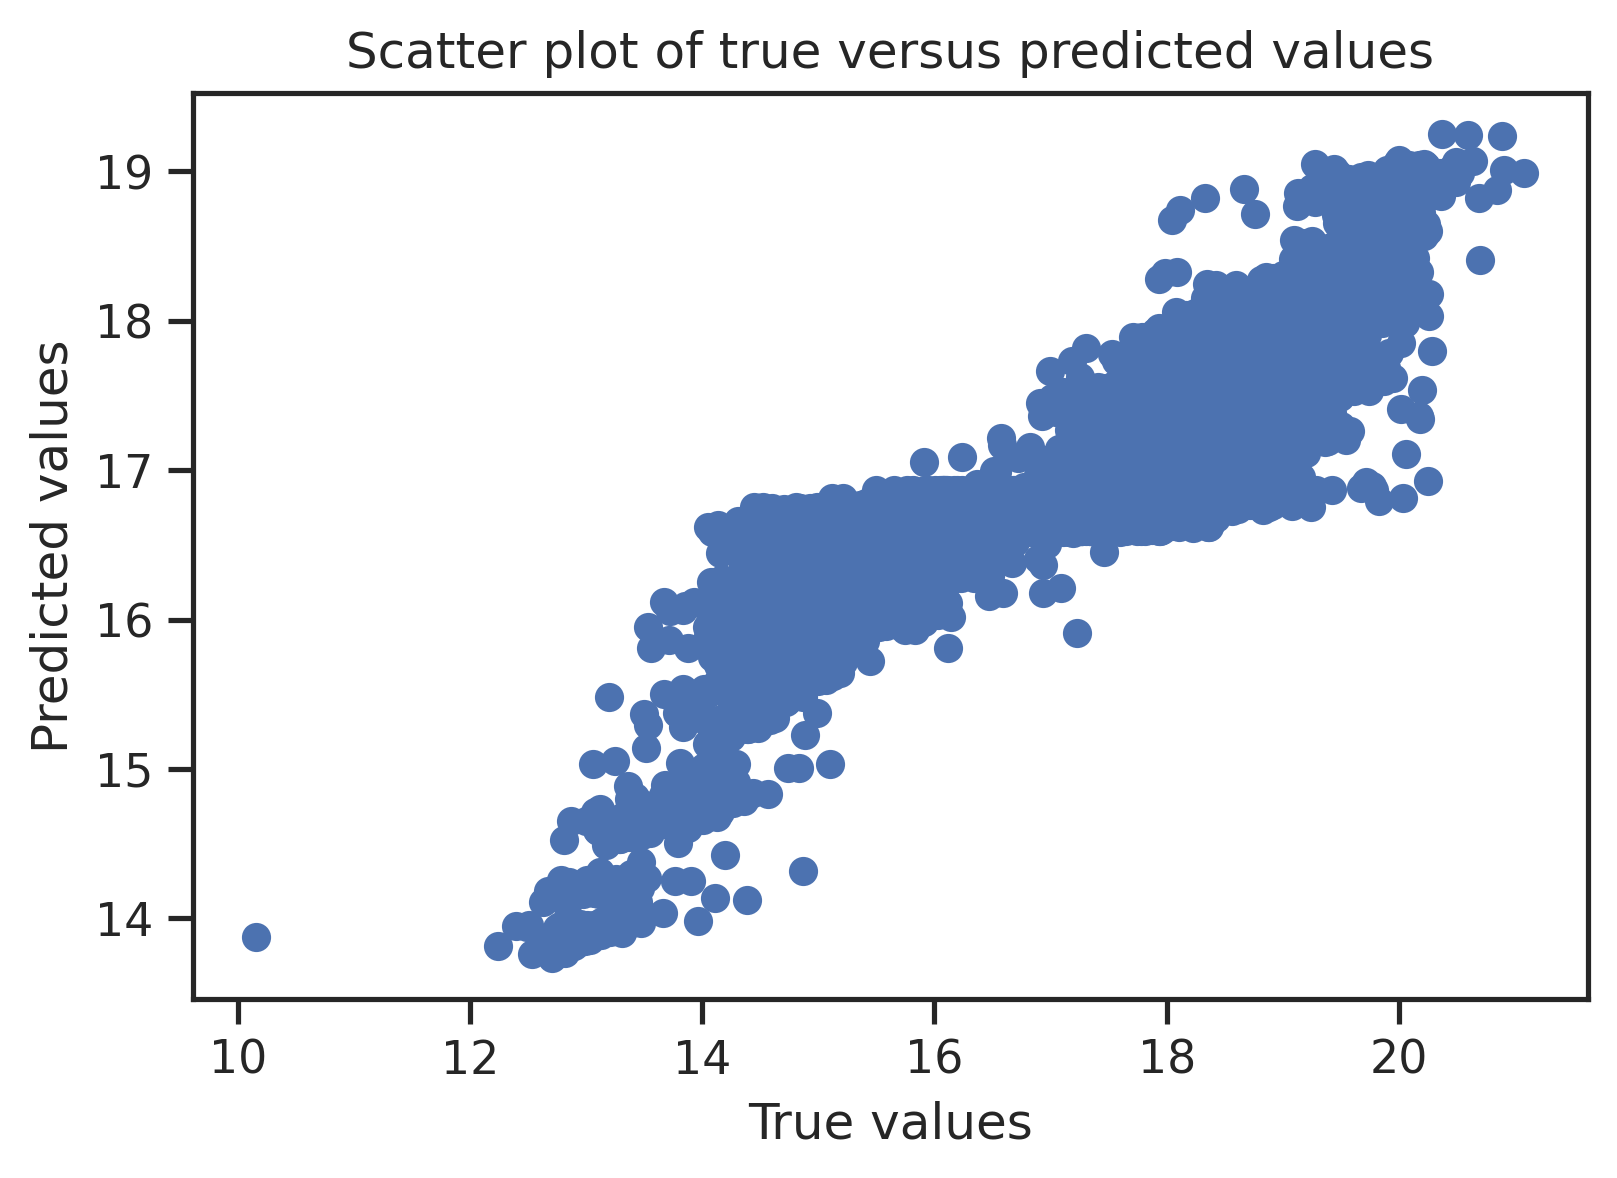

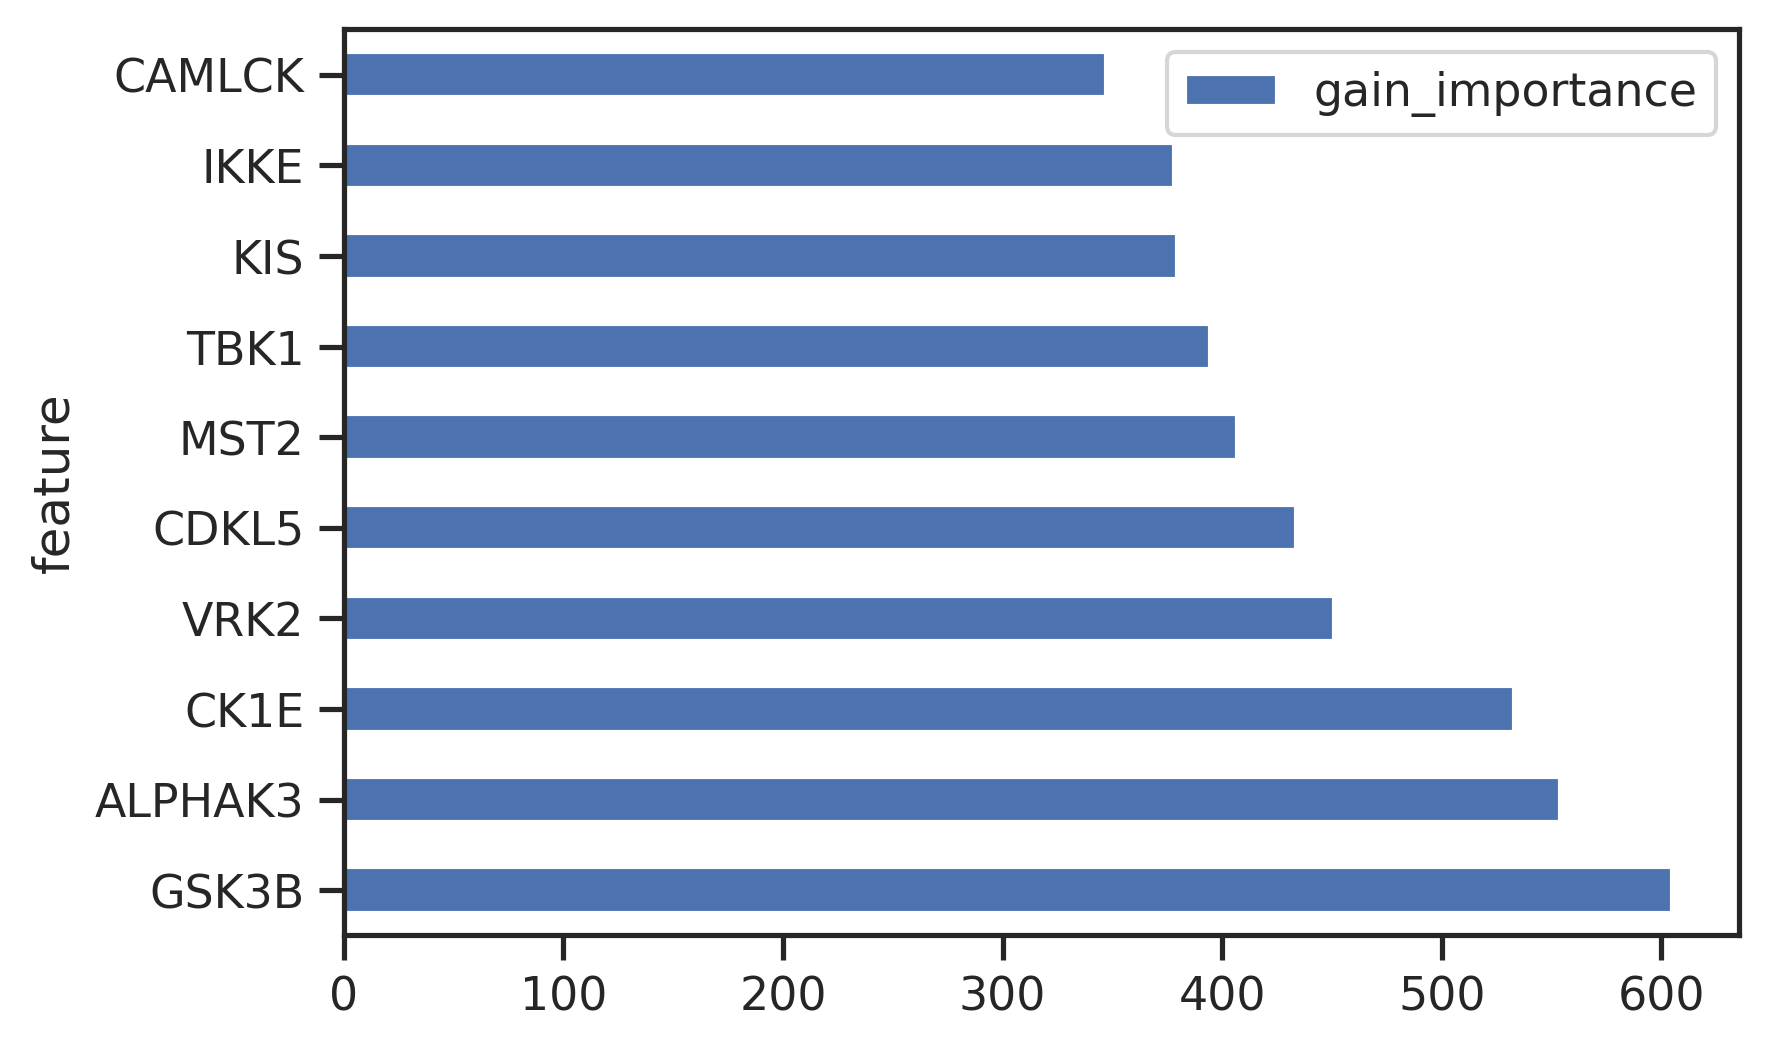

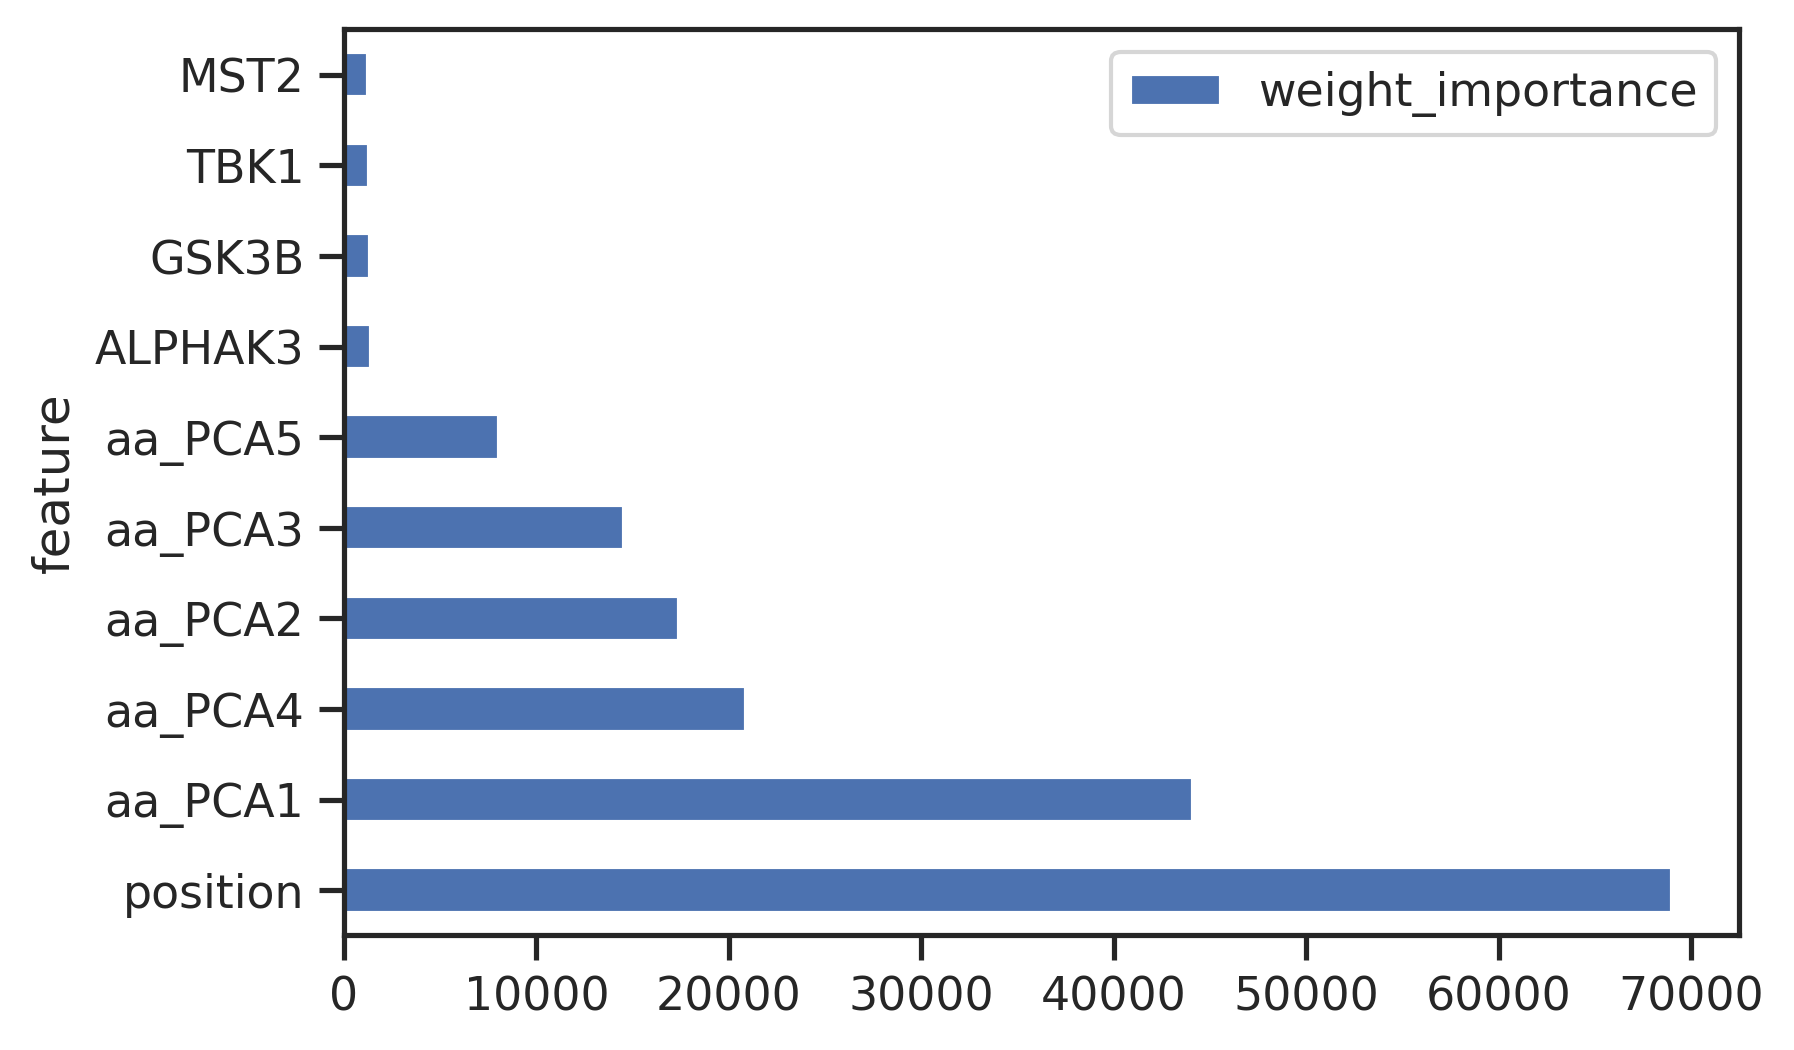

In [ ]:
FOLDS=5
pred_dfs = []
gains = []
weights = []
for fold, (train_idx, valid_idx) in enumerate(StratifiedGroupKFold(FOLDS).split(df2.index.values, df2.category,df2.kinase)):
    pred_df, gain, weight = xgb_trainer(df, feat_col, target_col = 'target', test_index=valid_idx, model_file = f'model/fold{fold}.bin')
    pred_dfs.append(pred_df)
    gains.append(gain)
    weights.append(weight)
    break

xgb params is: {'max_depth': 7, 'learning_rate': 0.001, 'subsample': 0.8, 'colsample_bytree': 1, 'eval_metric': 'rmse', 'objective': 'reg:squarederror', 'tree_method': 'gpu_hist', 'predictor': 'gpu_predictor', 'random_state': 123}
(47916, 38) (47916,) (12078, 38) (12078,)
Int64Index([    0,     1,     2,     3,     4,     5,     6,     7,     8,
                9,
            ...
            59588, 59589, 59590, 59591, 59592, 59593, 59594, 59595, 59596,
            59597],
           dtype='int64', length=12078)
[0]	train-rmse:16.30815	valid-rmse:16.29252
[100]	train-rmse:14.76309	valid-rmse:14.74738
[200]	train-rmse:13.36545	valid-rmse:13.34989
[300]	train-rmse:12.10065	valid-rmse:12.08506
[400]	train-rmse:10.95631	valid-rmse:10.94060
[500]	train-rmse:9.92106	valid-rmse:9.90525
[600]	train-rmse:8.98465	valid-rmse:8.96862
[700]	train-rmse:8.13780	valid-rmse:8.12251
[800]	train-rmse:7.37203	valid-rmse:7.35838
[900]	train-rmse:6.67986	valid-rmse:6.66736
[1000]	train-rmse:6.05416	valid-rm

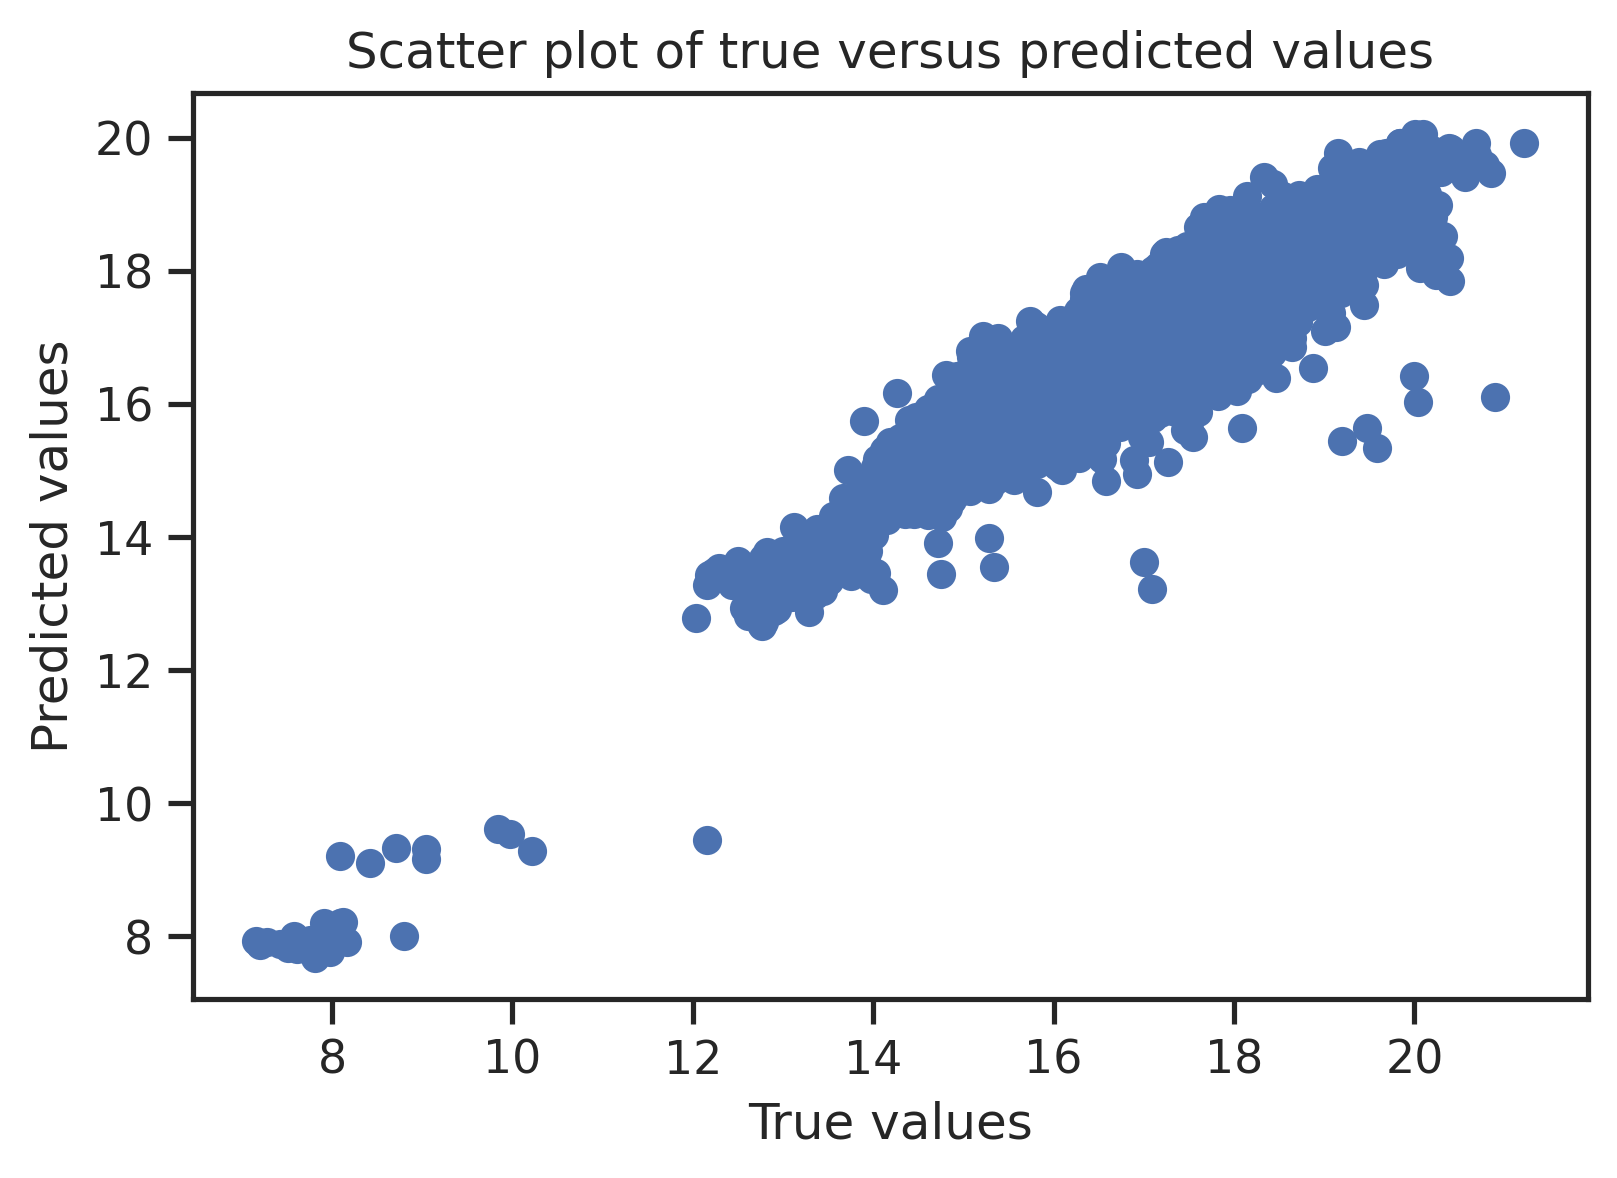

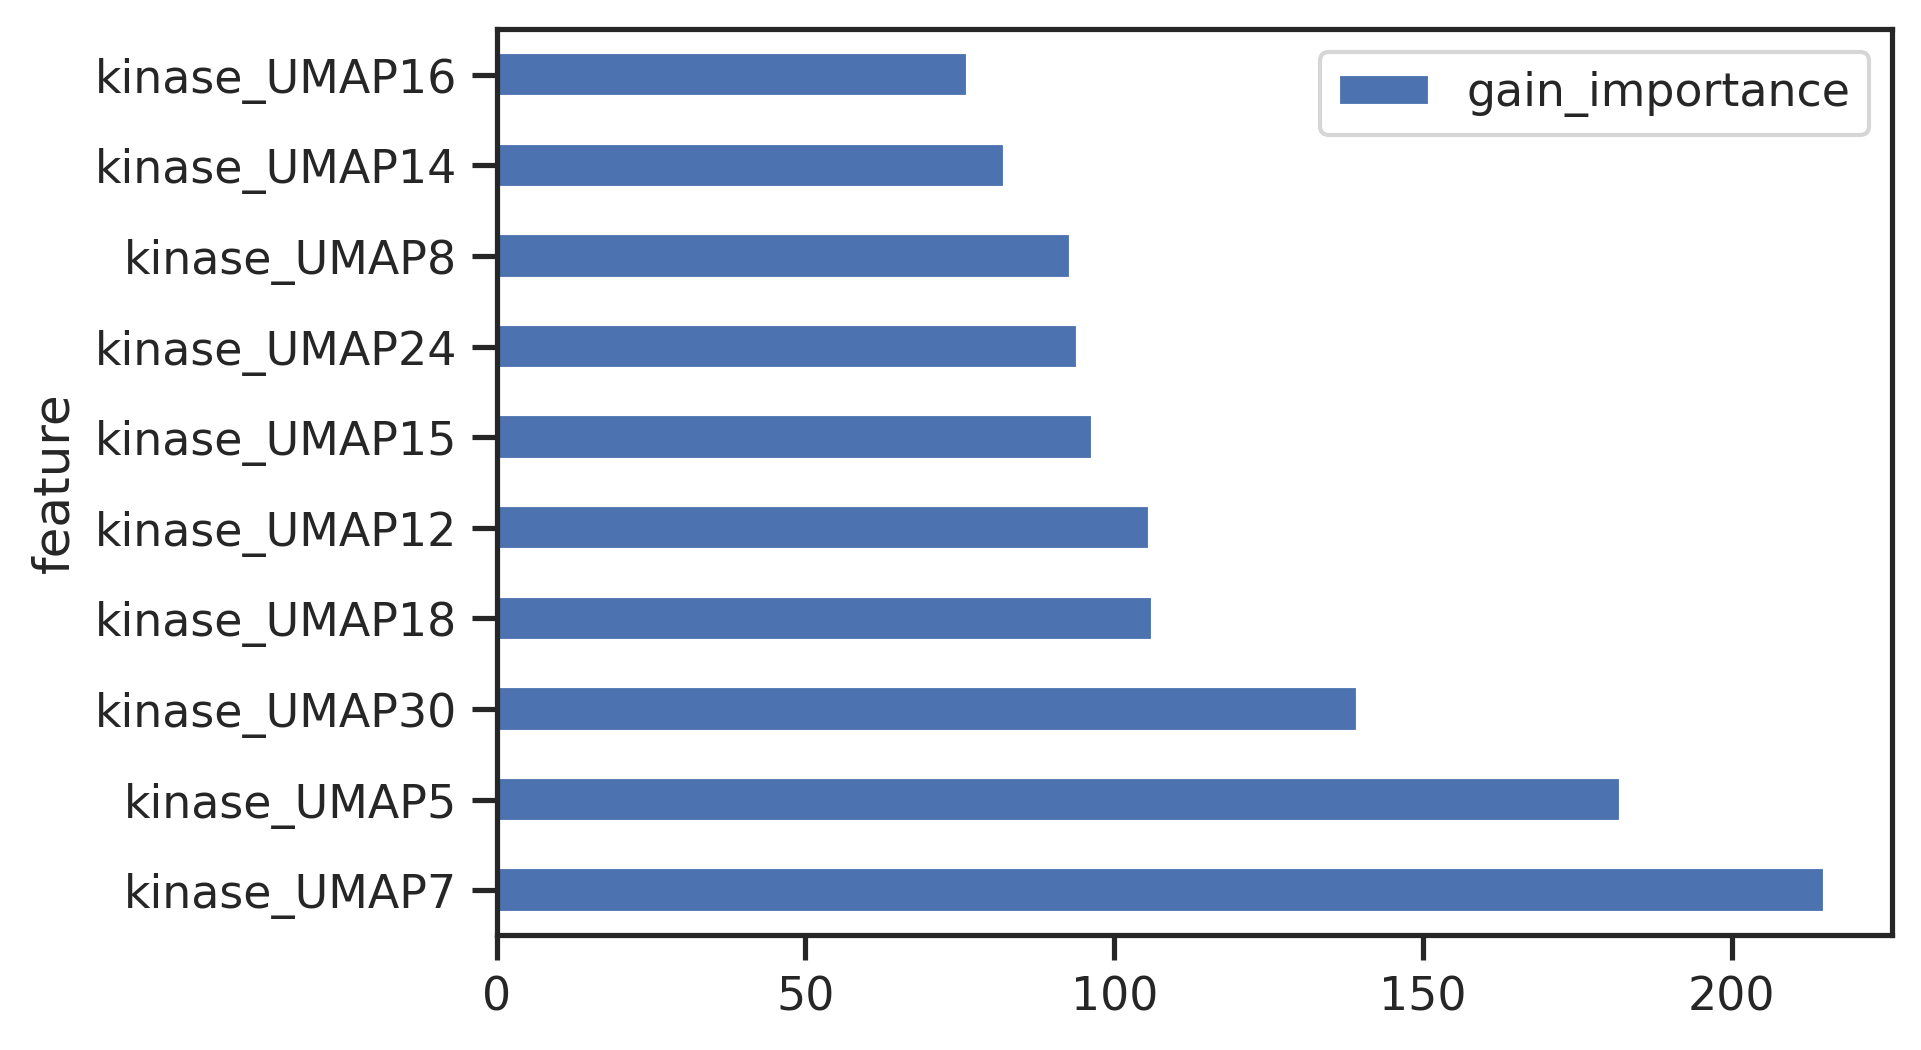

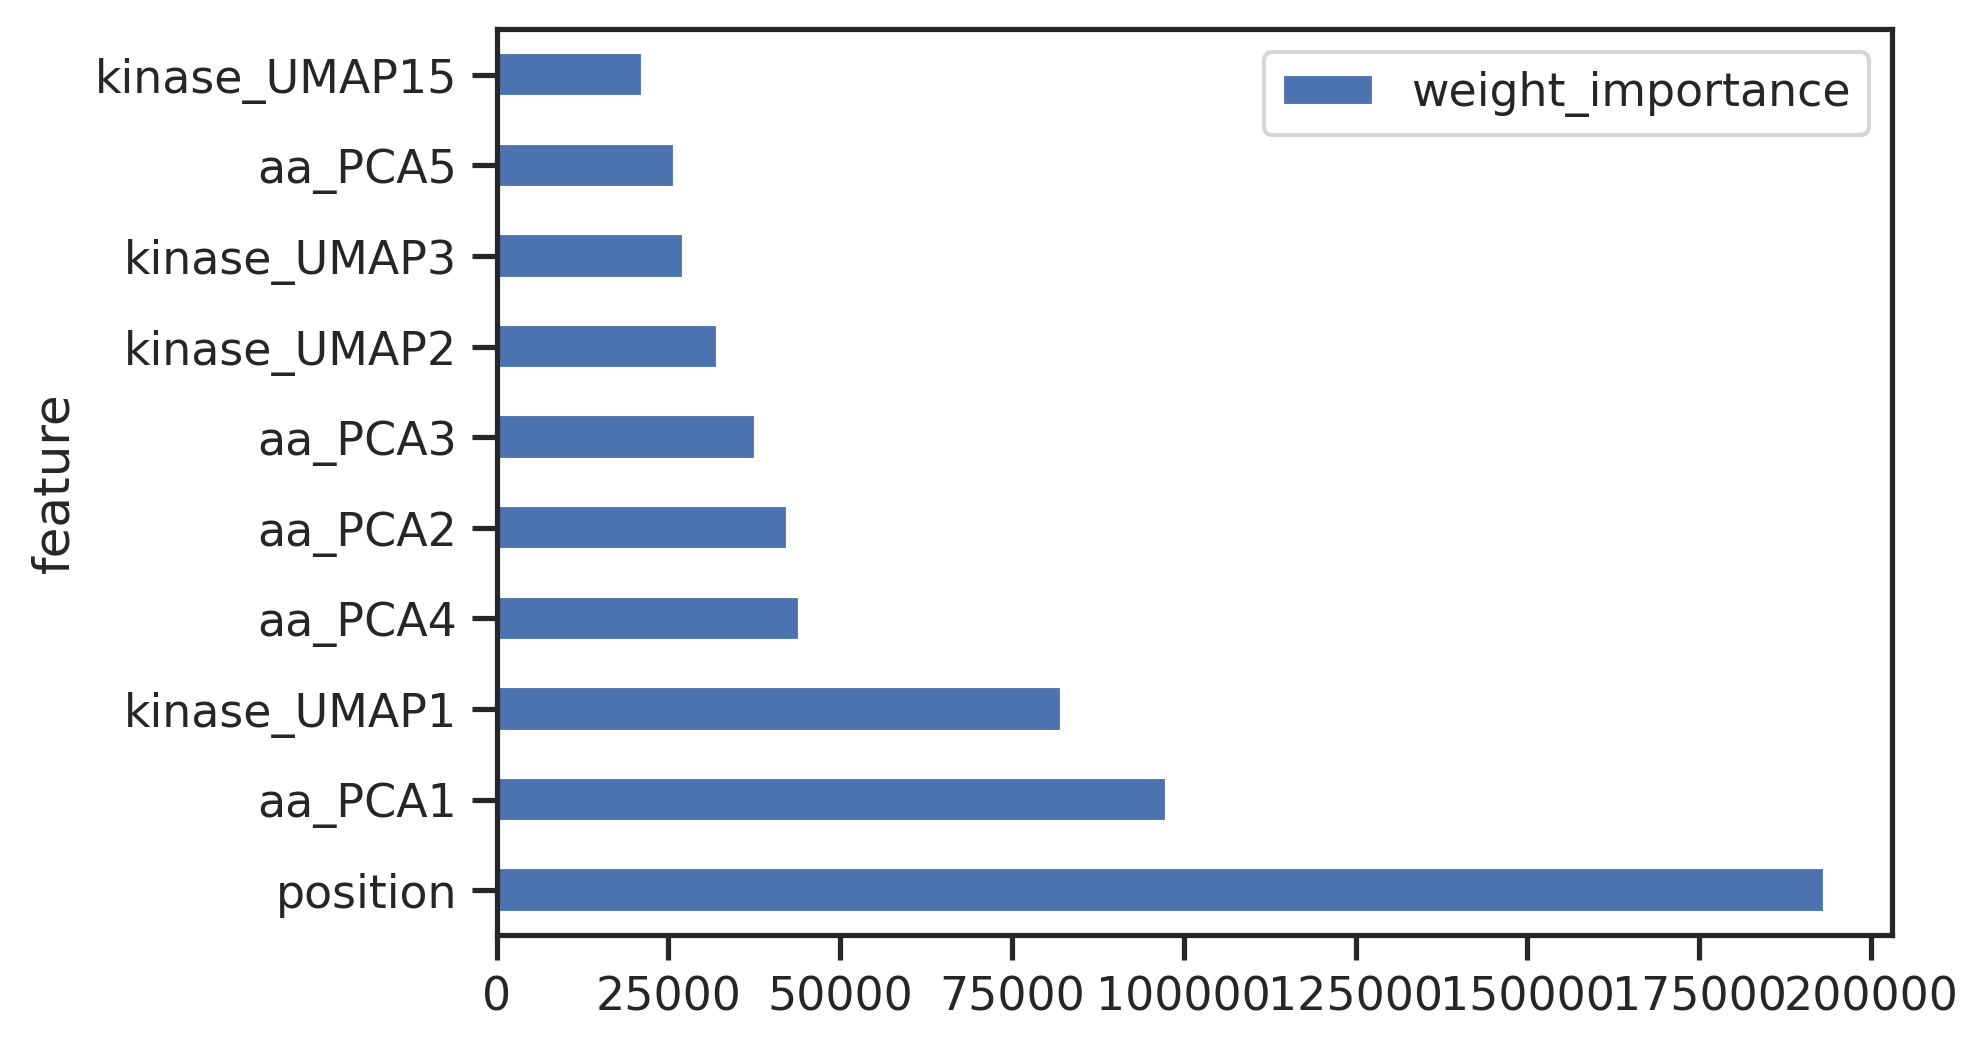

In [ ]:
FOLDS=5
pred_dfs = []
gains = []
weights = []
for fold, (train_idx, valid_idx) in enumerate(StratifiedGroupKFold(FOLDS).split(df2.index.values, df2.category,df2.kinase)):
    pred_df, gain, weight = xgb_trainer(df, feat_col, target_col = 'target', test_index=valid_idx, model_file = f'model/fold{fold}.bin')
    pred_dfs.append(pred_df)
    gains.append(gain)
    weights.append(weight)
    break

xgb params is: {'max_depth': 7, 'learning_rate': 0.001, 'subsample': 0.8, 'colsample_bytree': 1, 'eval_metric': 'rmse', 'objective': 'reg:squarederror', 'tree_method': 'gpu_hist', 'predictor': 'gpu_predictor', 'random_state': 123}
(47916, 326) (47916,) (12078, 326) (12078,)
Int64Index([    0,     1,     2,     3,     4,     5,     6,     7,     8,
                9,
            ...
            59588, 59589, 59590, 59591, 59592, 59593, 59594, 59595, 59596,
            59597],
           dtype='int64', length=12078)
[0]	train-rmse:16.30110	valid-rmse:16.32064
[100]	train-rmse:14.75899	valid-rmse:14.77809
[200]	train-rmse:13.36468	valid-rmse:13.38346
[300]	train-rmse:12.10416	valid-rmse:12.12268
[400]	train-rmse:10.96478	valid-rmse:10.98307
[500]	train-rmse:9.93518	valid-rmse:9.95326
[600]	train-rmse:9.00486	valid-rmse:9.02280
[700]	train-rmse:8.16465	valid-rmse:8.18249
[800]	train-rmse:7.40599	valid-rmse:7.42375
[900]	train-rmse:6.72126	valid-rmse:6.73896
[1000]	train-rmse:6.10363	valid-

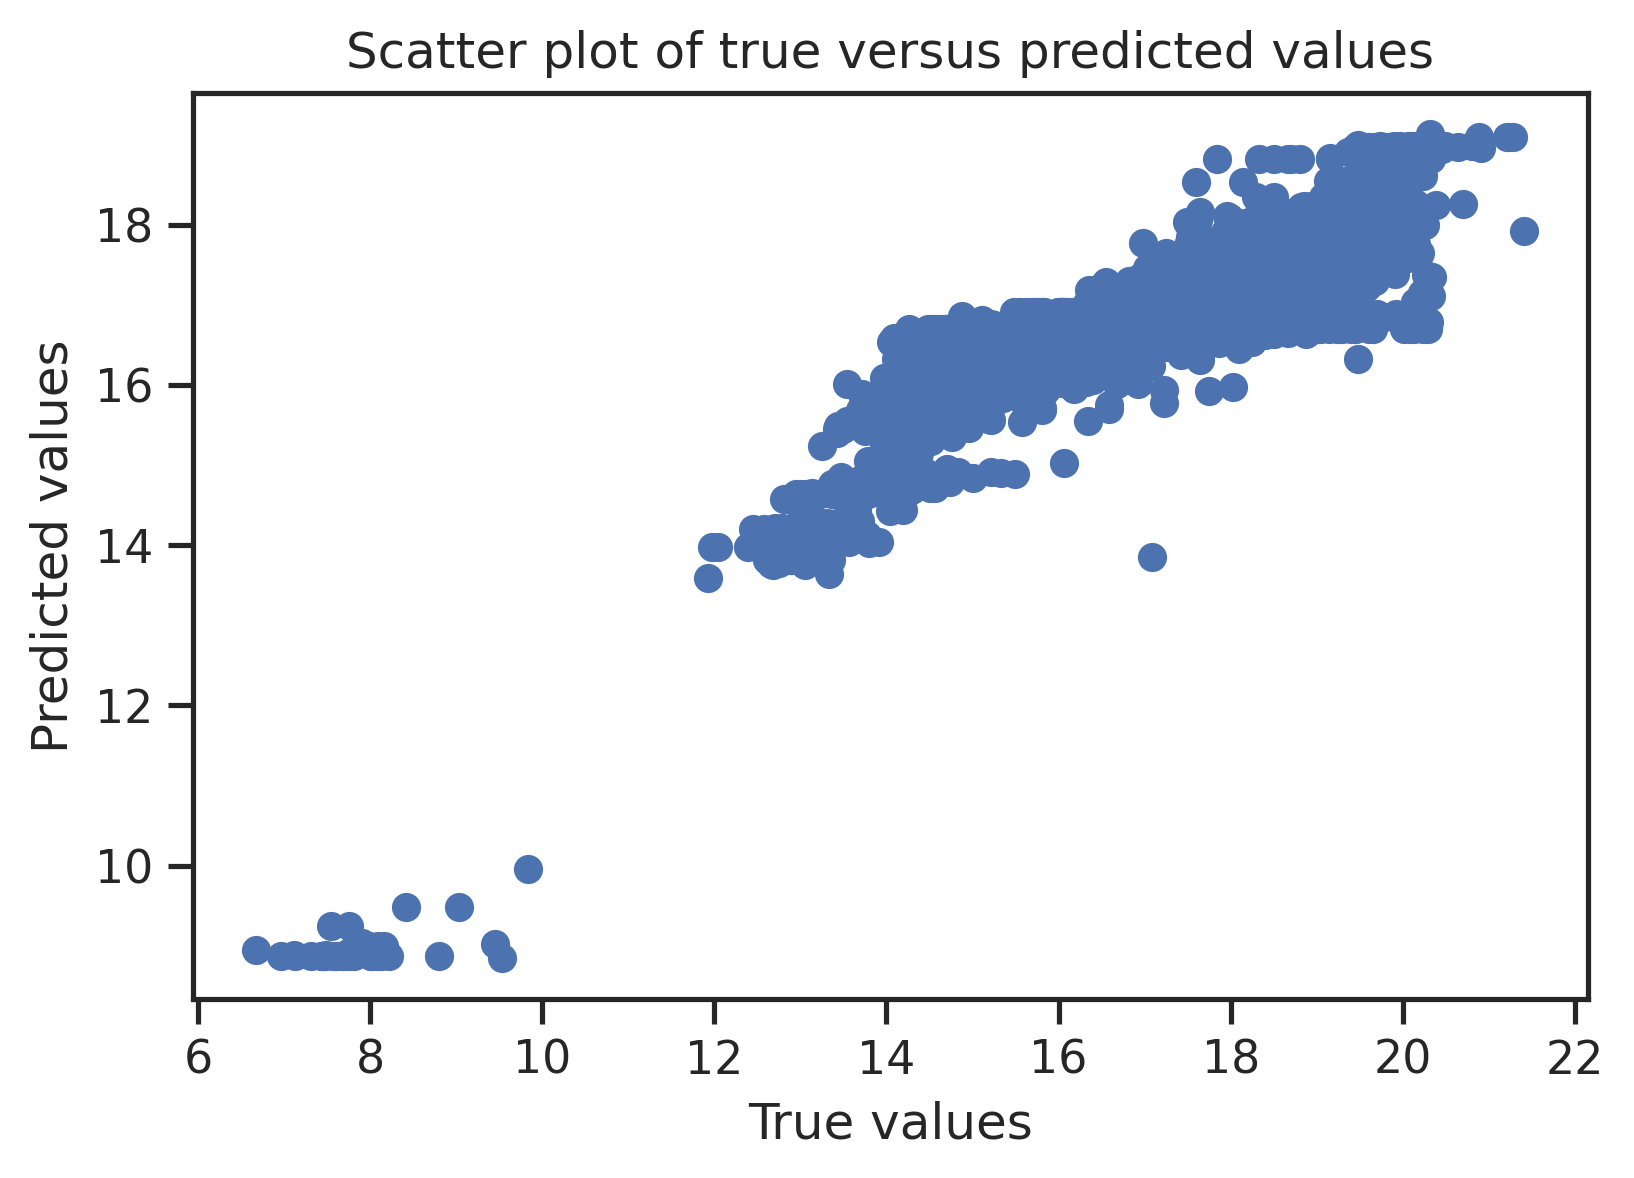

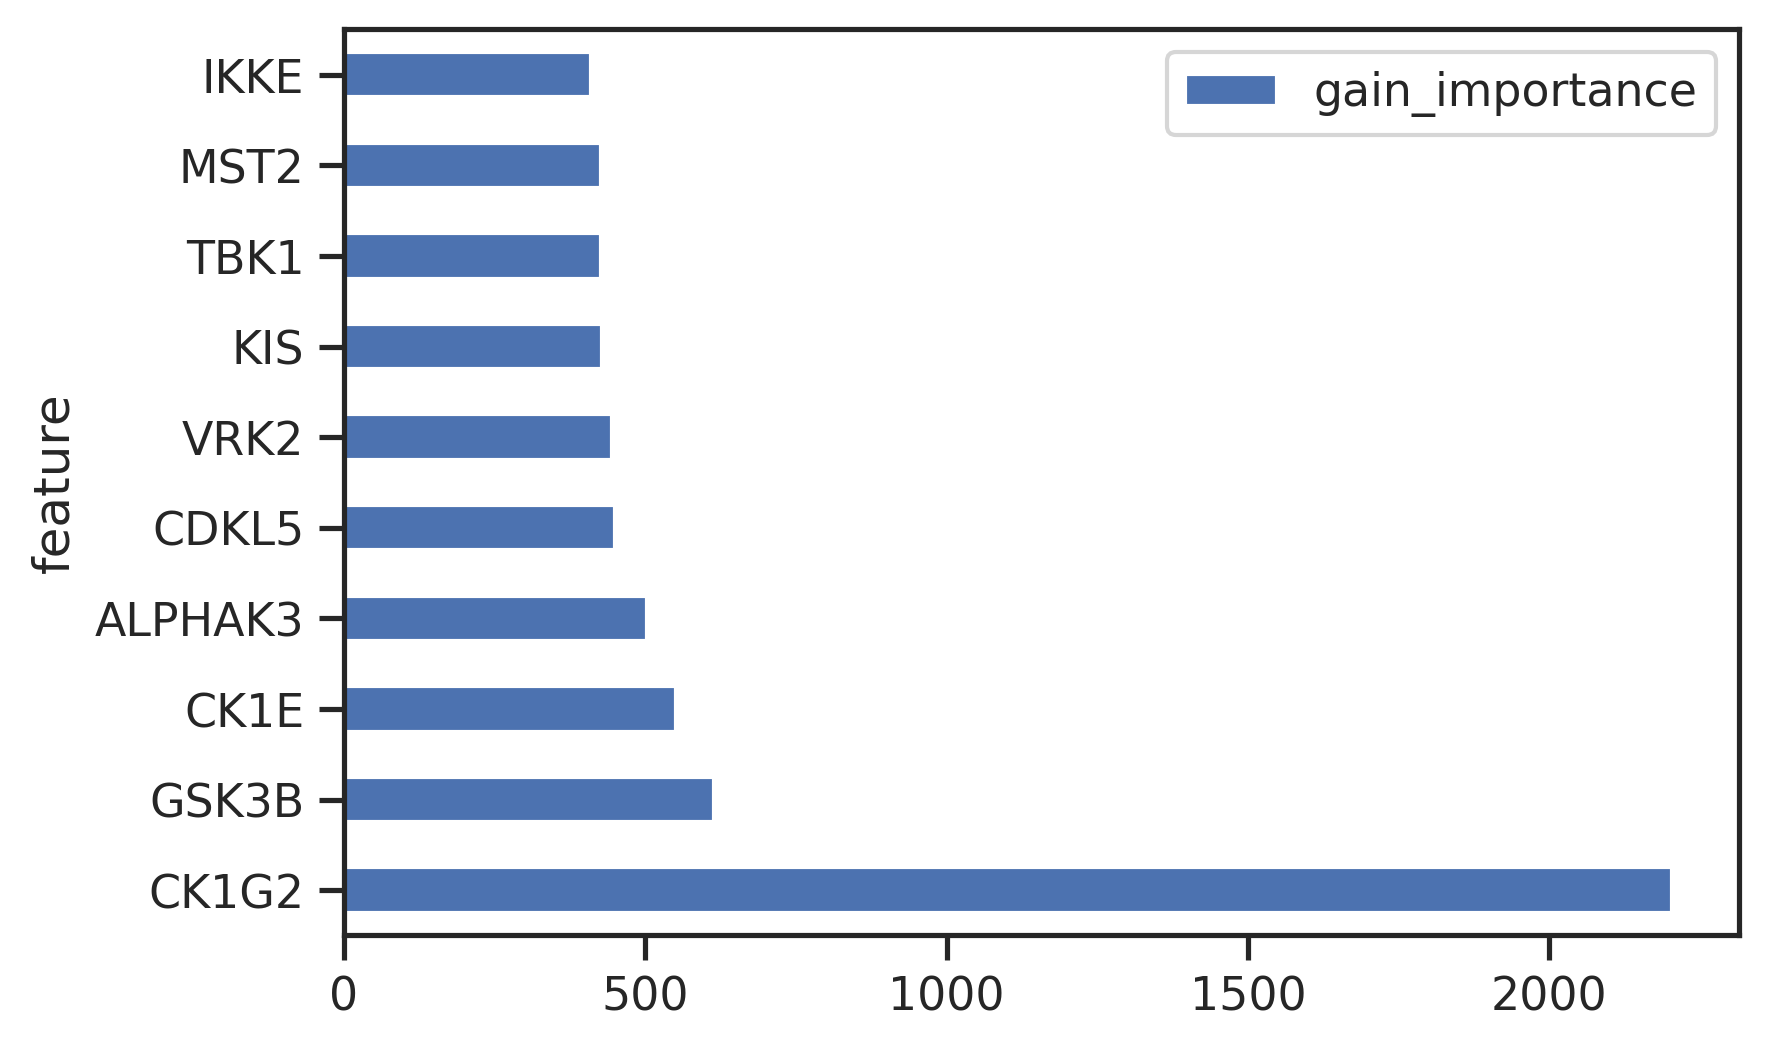

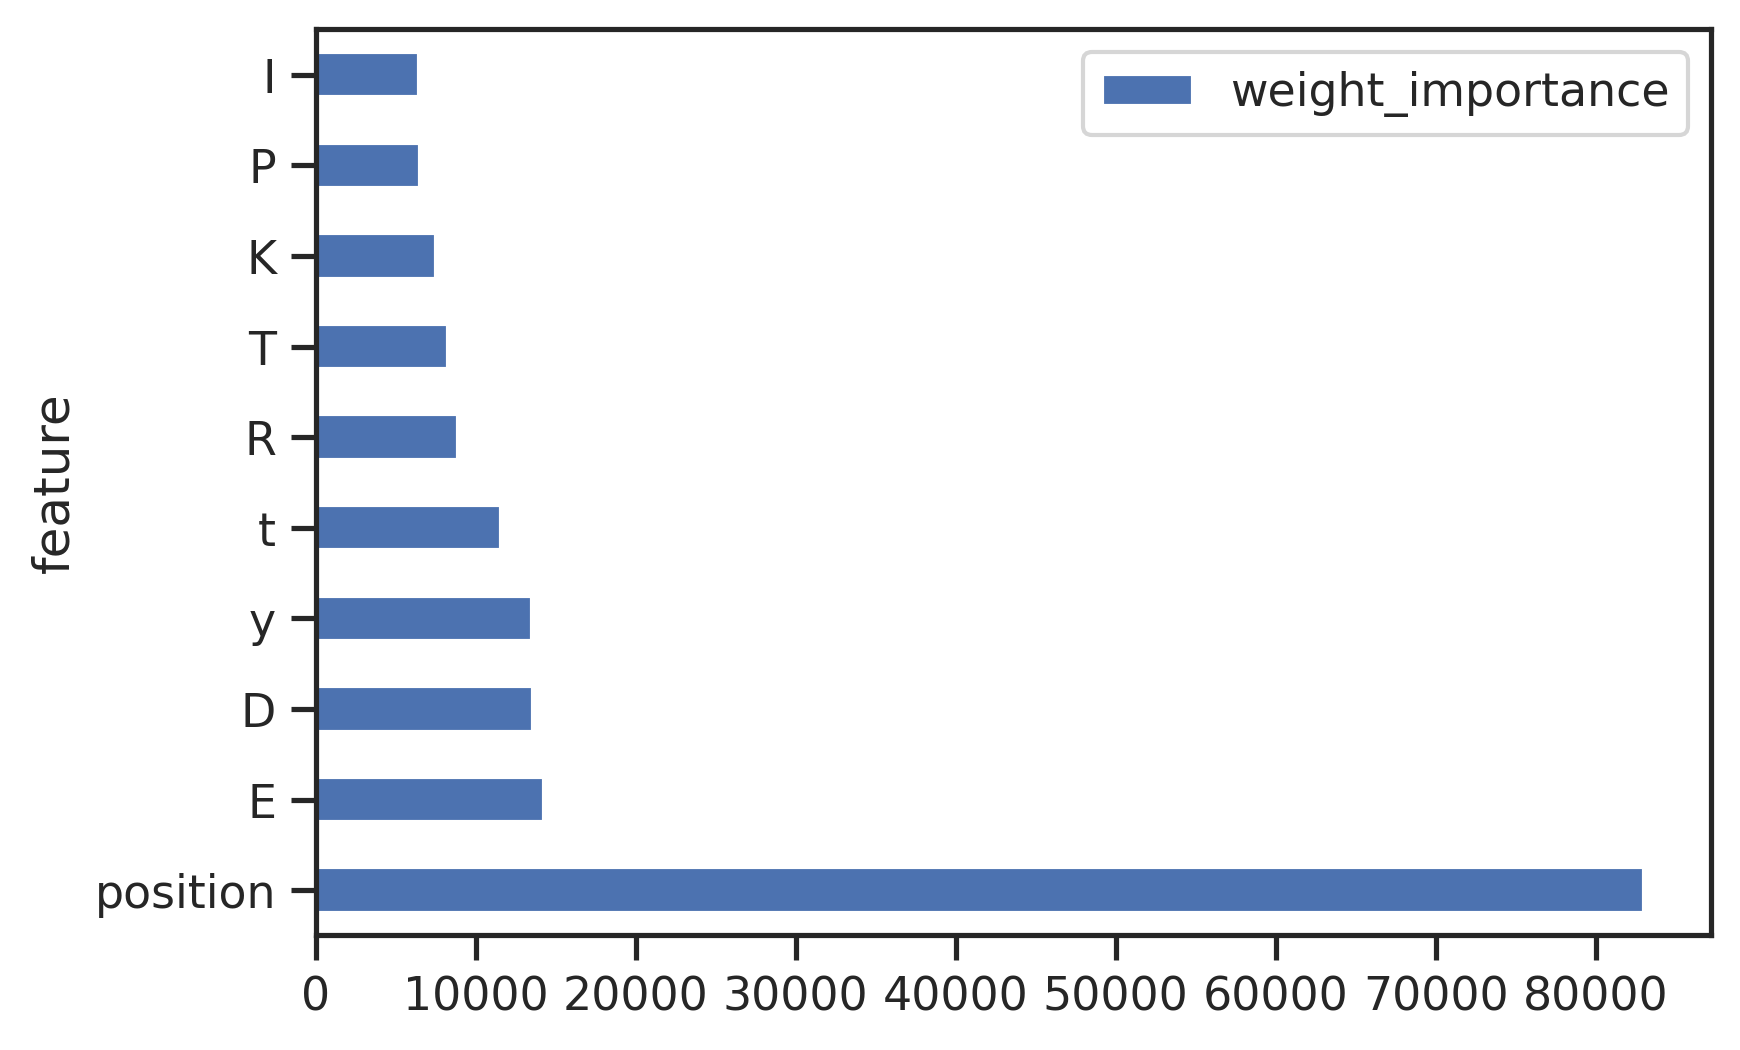

In [ ]:
FOLDS=5
pred_dfs = []
gains = []
weights = []
for fold, (train_idx, valid_idx) in enumerate(StratifiedGroupKFold(FOLDS).split(df2.index.values, df2.category,df2.kinase)):
    pred_df, gain, weight = xgb_trainer(df, feat_col, target_col = 'target', test_index=valid_idx, model_file = f'model/fold{fold}.bin')
    pred_dfs.append(pred_df)
    gains.append(gain)
    weights.append(weight)
    break

xgb params is: {'max_depth': 7, 'learning_rate': 0.001, 'subsample': 0.8, 'colsample_bytree': 1, 'eval_metric': 'rmse', 'objective': 'reg:squarederror', 'tree_method': 'gpu_hist', 'predictor': 'gpu_predictor', 'random_state': 123}
(47916, 38) (47916,) (12078, 38) (12078,)
Int64Index([    0,     1,     2,     3,     4,     5,     6,     7,     8,
                9,
            ...
            59588, 59589, 59590, 59591, 59592, 59593, 59594, 59595, 59596,
            59597],
           dtype='int64', length=12078)
[0]	train-rmse:16.30815	valid-rmse:16.29252
[100]	train-rmse:14.76309	valid-rmse:14.74738
[200]	train-rmse:13.36545	valid-rmse:13.34989
[300]	train-rmse:12.10065	valid-rmse:12.08506
[400]	train-rmse:10.95631	valid-rmse:10.94060
[500]	train-rmse:9.92106	valid-rmse:9.90525
[600]	train-rmse:8.98465	valid-rmse:8.96862
[700]	train-rmse:8.13780	valid-rmse:8.12251
[800]	train-rmse:7.37203	valid-rmse:7.35838
[900]	train-rmse:6.67986	valid-rmse:6.66736
[1000]	train-rmse:6.05416	valid-rm

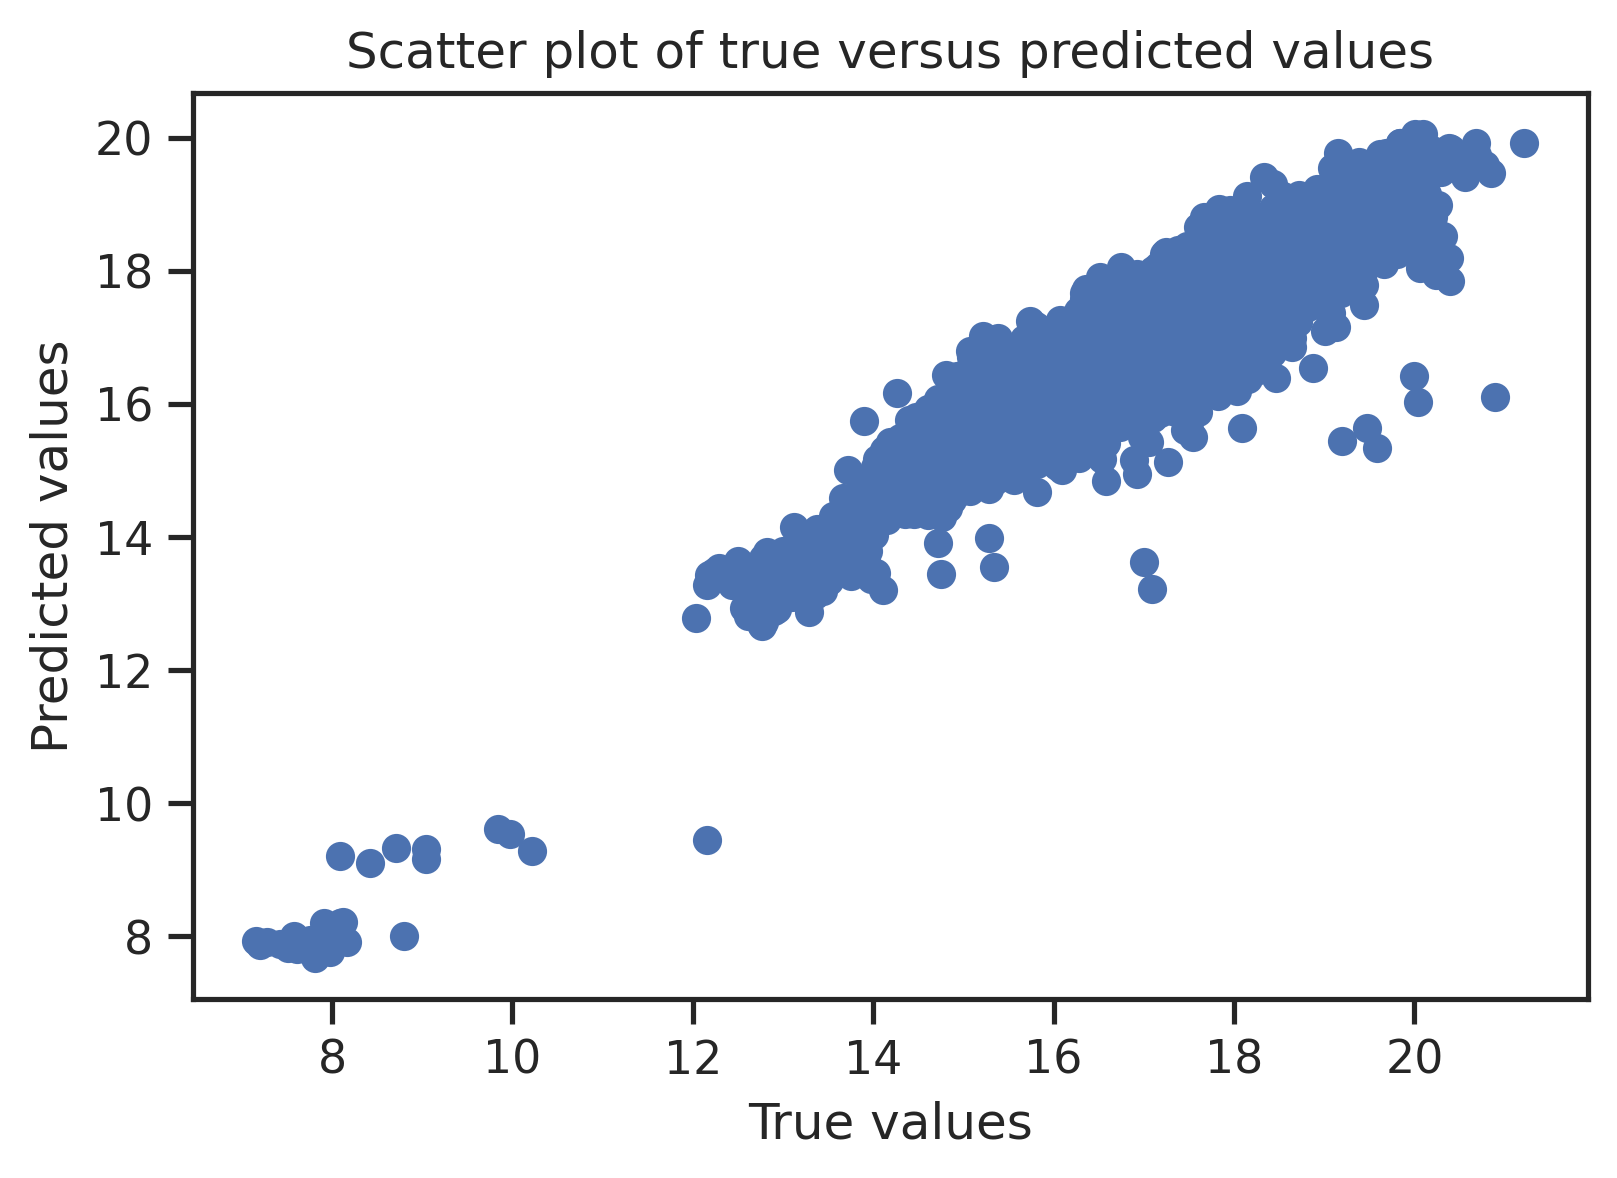

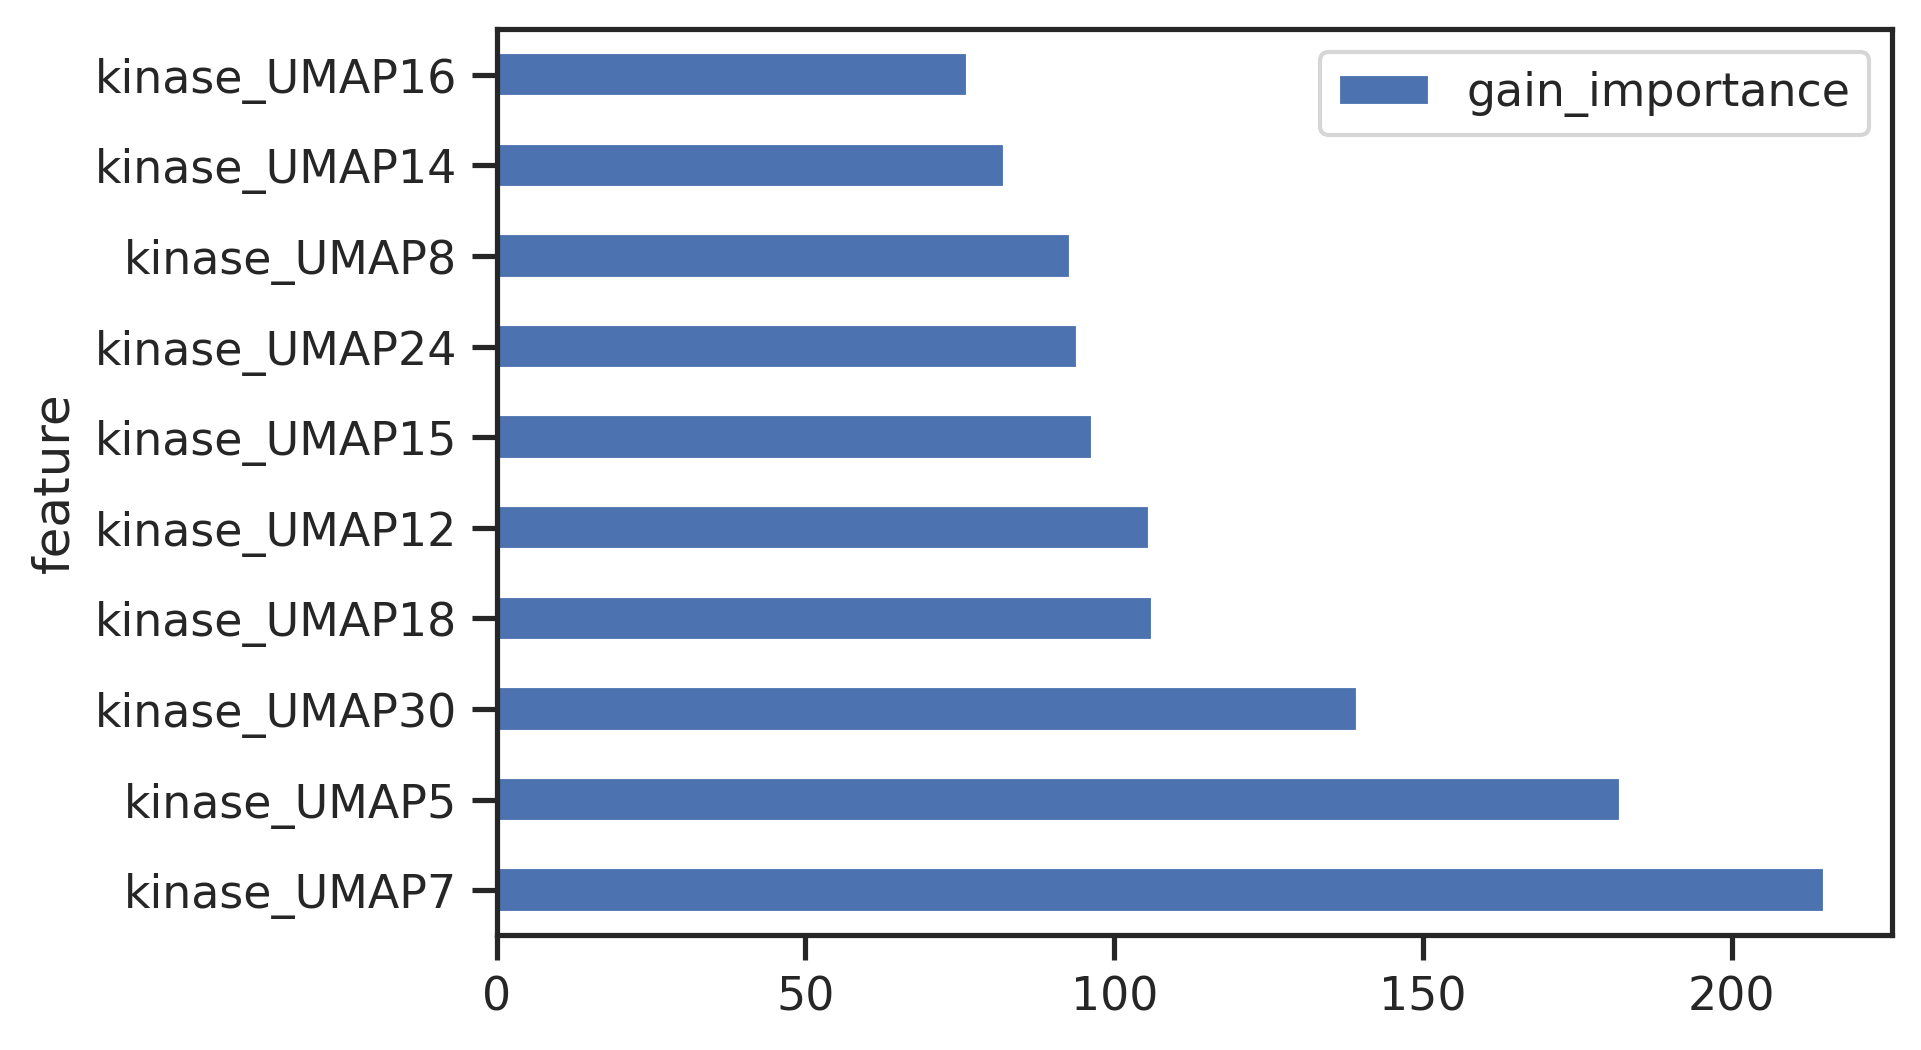

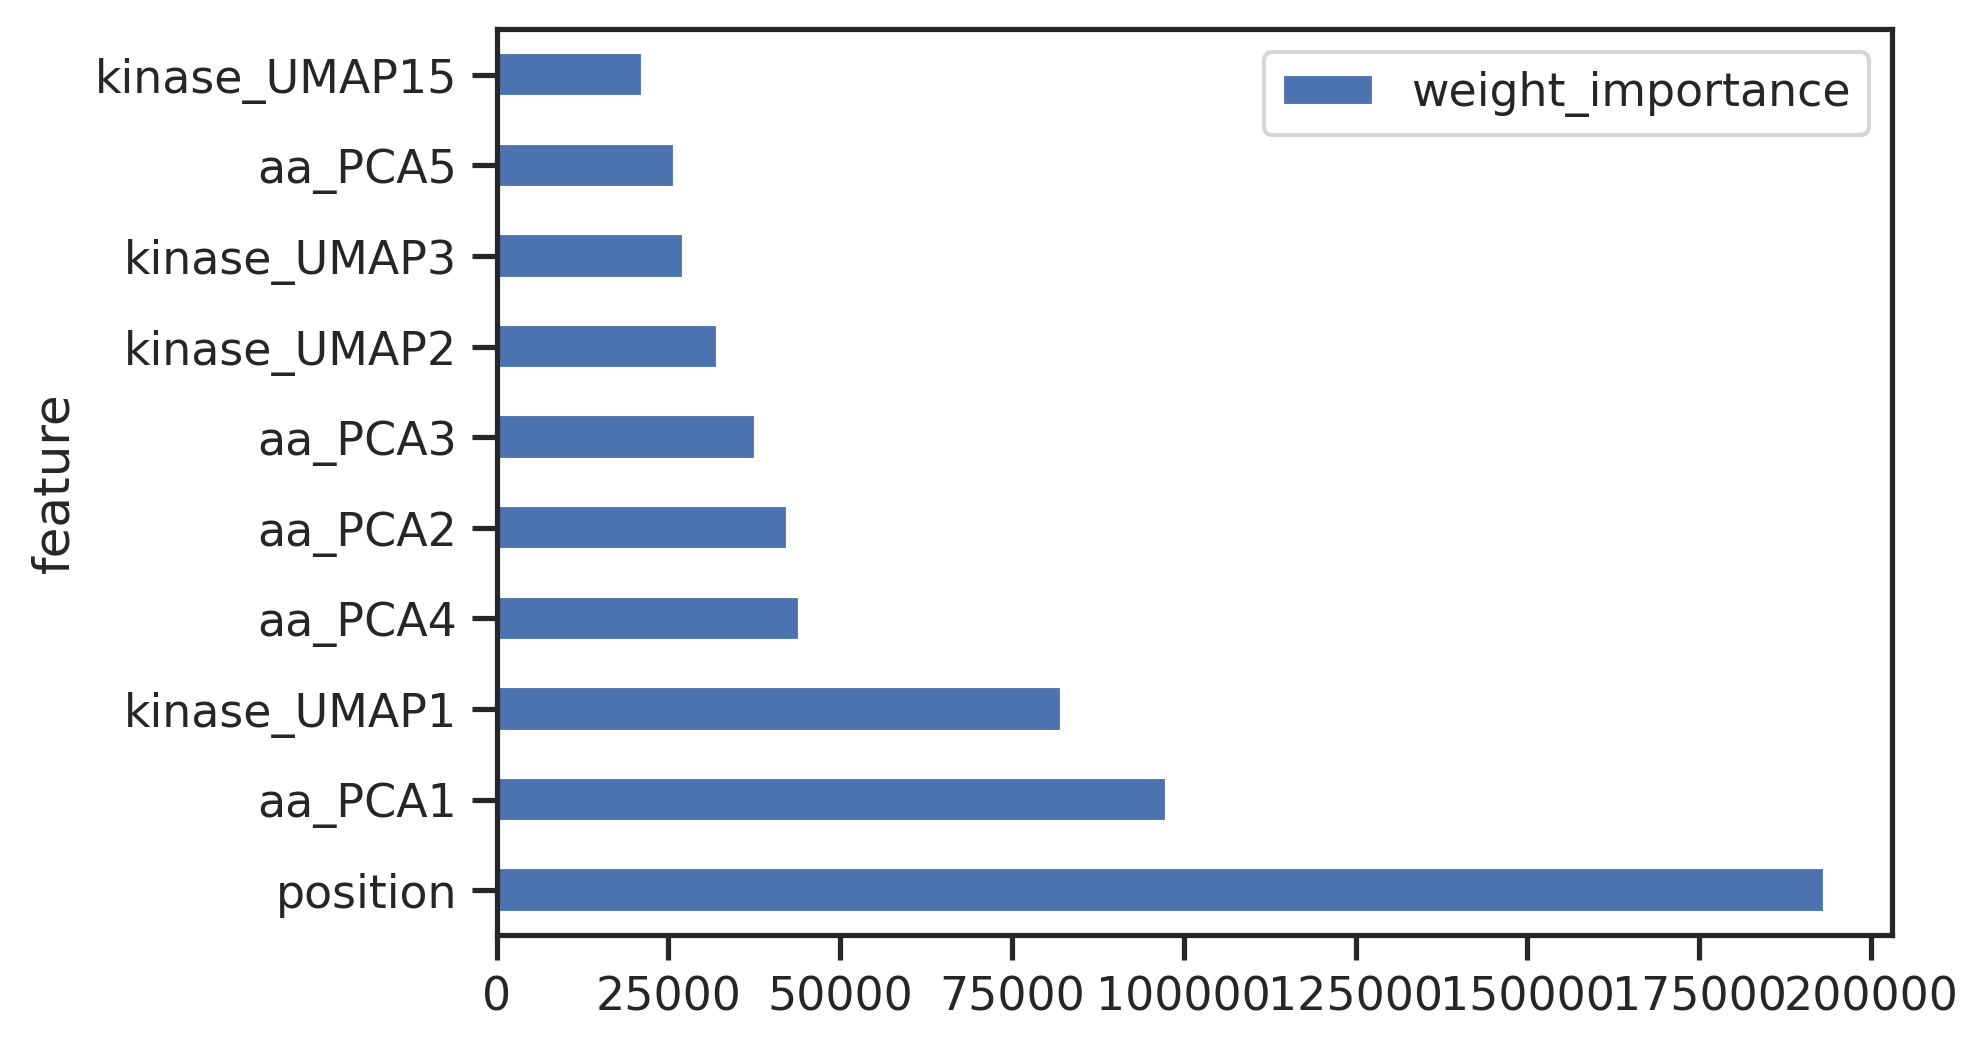

In [ ]:
FOLDS=5
pred_dfs = []
gains = []
weights = []
for fold, (train_idx, valid_idx) in enumerate(StratifiedGroupKFold(FOLDS).split(df2.index.values, df2.category,df2.kinase)):
    pred_df, gain, weight = xgb_trainer(df, feat_col, target_col = 'target', test_index=valid_idx, model_file = f'model/fold{fold}.bin')
    pred_dfs.append(pred_df)
    gains.append(gain)
    weights.append(weight)
    break

xgb params is: {'max_depth': 7, 'learning_rate': 0.001, 'subsample': 0.8, 'colsample_bytree': 1, 'eval_metric': 'rmse', 'objective': 'reg:squarederror', 'tree_method': 'gpu_hist', 'predictor': 'gpu_predictor', 'random_state': 123}
(47916, 38) (47916,) (12078, 38) (12078,)
Int64Index([    0,     1,     2,     3,     4,     5,     6,     7,     8,
                9,
            ...
            59588, 59589, 59590, 59591, 59592, 59593, 59594, 59595, 59596,
            59597],
           dtype='int64', length=12078)
[0]	train-rmse:1.10368	valid-rmse:1.15063
[100]	train-rmse:1.06054	valid-rmse:1.11333
[200]	train-rmse:1.02301	valid-rmse:1.08145
[300]	train-rmse:0.99026	valid-rmse:1.05427
[400]	train-rmse:0.96181	valid-rmse:1.03109
[500]	train-rmse:0.93718	valid-rmse:1.01128
[600]	train-rmse:0.91588	valid-rmse:0.99456
[700]	train-rmse:0.89728	valid-rmse:0.98026
[800]	train-rmse:0.88122	valid-rmse:0.96805
[900]	train-rmse:0.86722	valid-rmse:0.95781
[1000]	train-rmse:0.85495	valid-rmse:0.94915

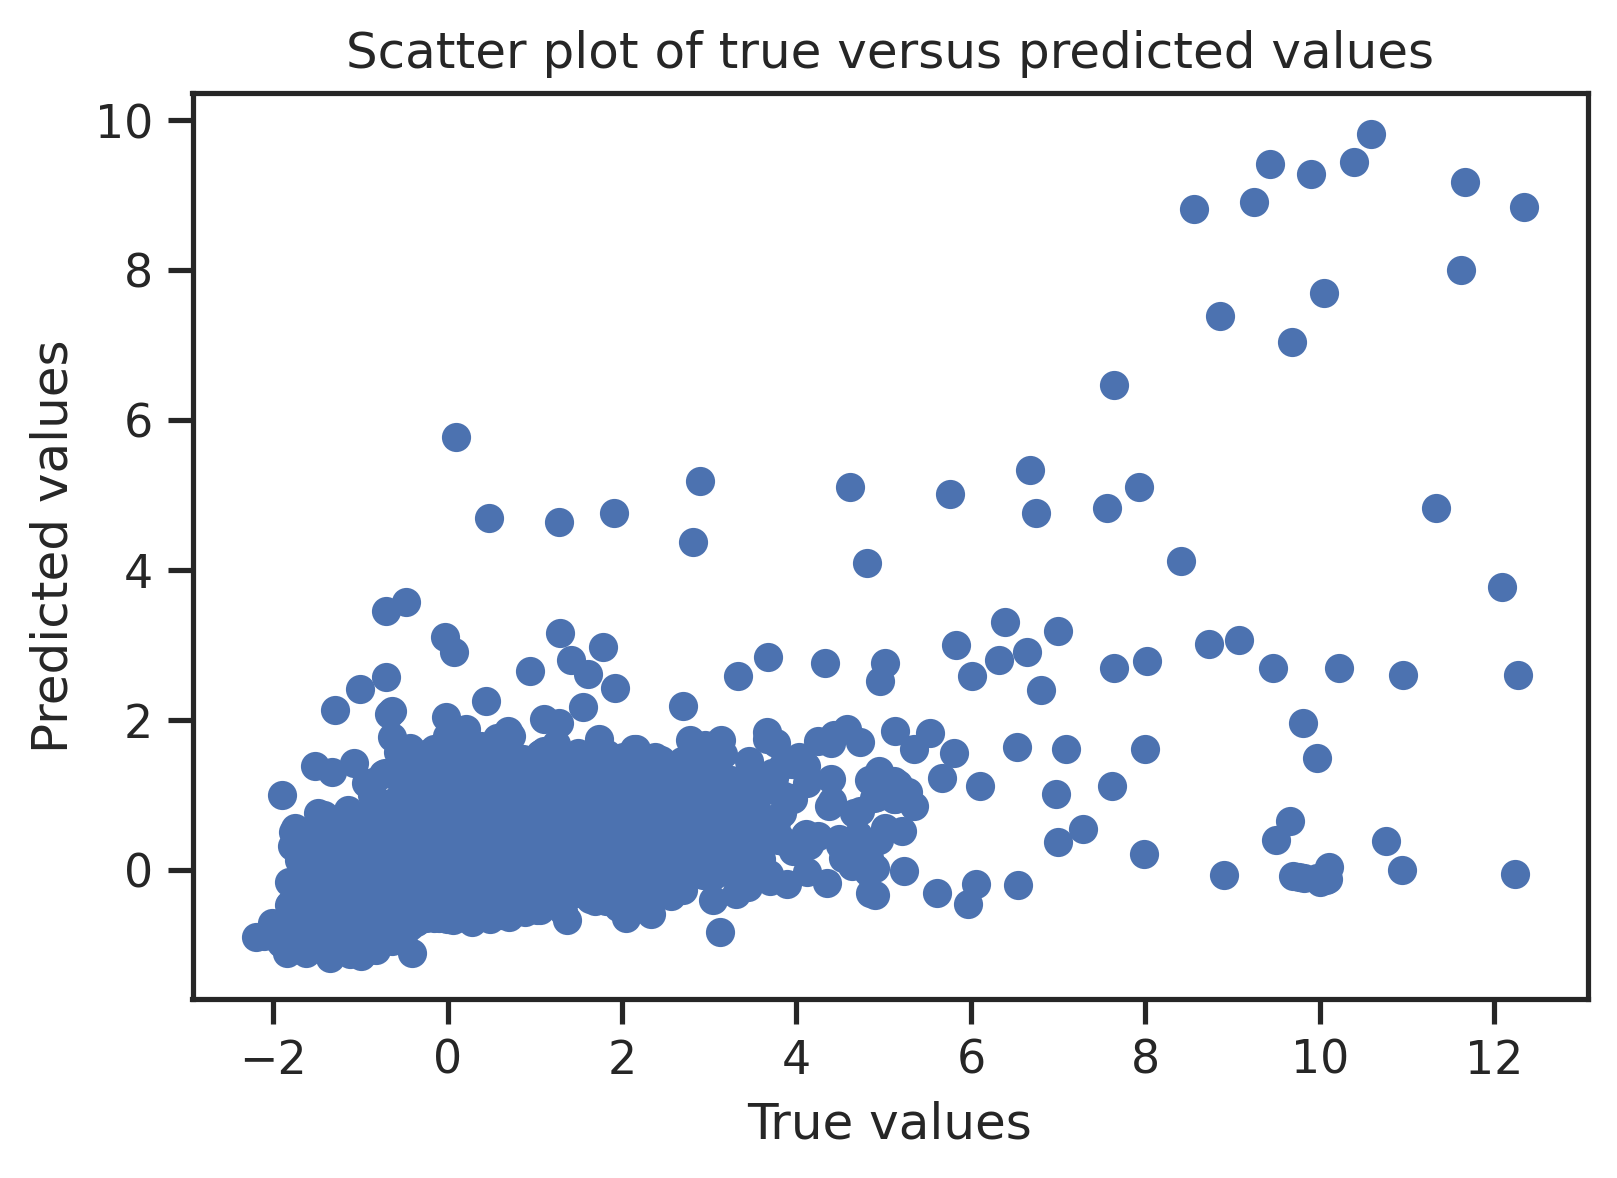

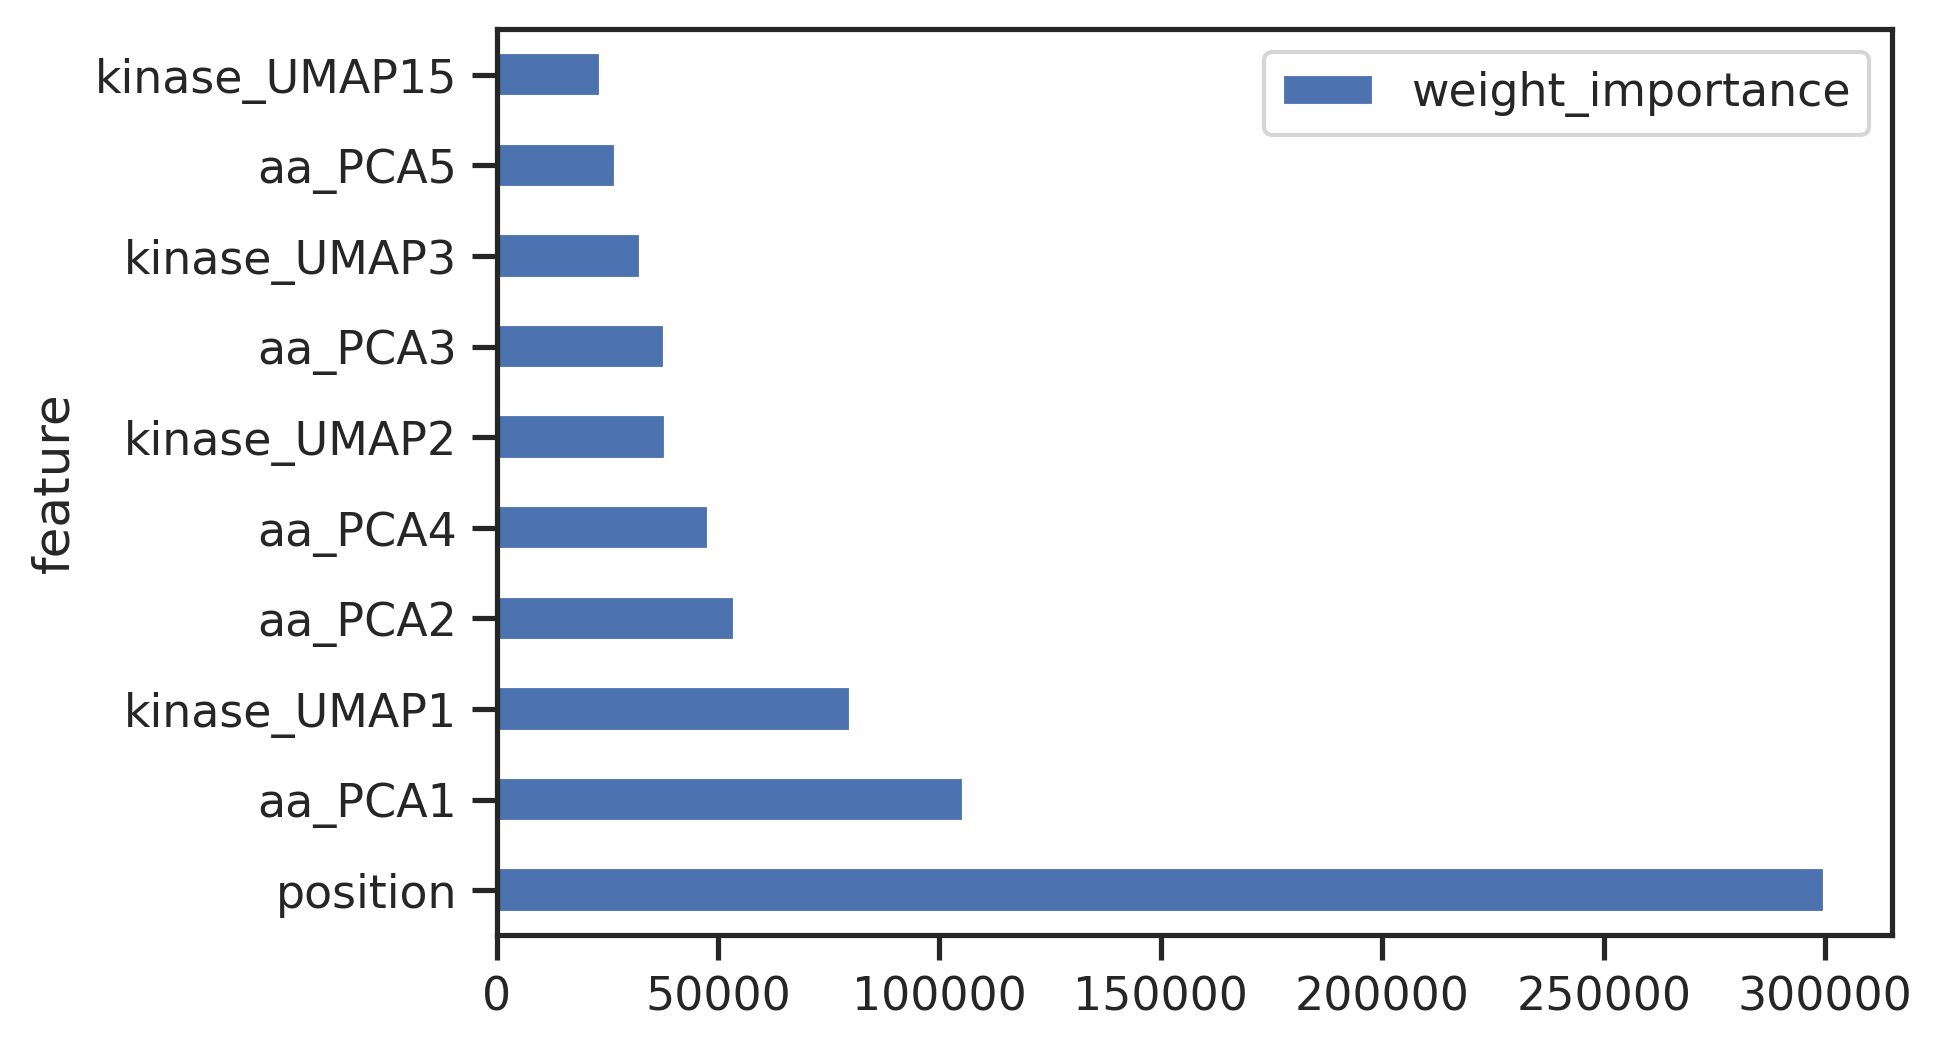

In [ ]:
FOLDS=5
pred_dfs = []
gains = []
weights = []
for fold, (train_idx, valid_idx) in enumerate(StratifiedGroupKFold(FOLDS).split(df2.index.values, df2.category,df2.kinase)):
    pred_df, gain, weight = xgb_trainer(df, feat_col, target_col = 'target', test_index=valid_idx, model_file = f'model/fold{fold}.bin')
    pred_dfs.append(pred_df)
    gains.append(gain)
    weights.append(weight)
    break

xgb params is: {'max_depth': 7, 'learning_rate': 0.001, 'subsample': 0.8, 'colsample_bytree': 1, 'eval_metric': 'rmse', 'objective': 'reg:squarederror', 'tree_method': 'gpu_hist', 'predictor': 'gpu_predictor', 'random_state': 123}
(47916, 326) (47916,) (12078, 326) (12078,)
Int64Index([    0,     1,     2,     3,     4,     5,     6,     7,     8,
                9,
            ...
            59588, 59589, 59590, 59591, 59592, 59593, 59594, 59595, 59596,
            59597],
           dtype='int64', length=12078)
[0]	train-rmse:1.06857	valid-rmse:1.27563
[100]	train-rmse:1.03270	valid-rmse:1.24503
[200]	train-rmse:1.00221	valid-rmse:1.21979
[300]	train-rmse:0.97636	valid-rmse:1.19907
[400]	train-rmse:0.95440	valid-rmse:1.18207
[500]	train-rmse:0.93579	valid-rmse:1.16830
[600]	train-rmse:0.92002	valid-rmse:1.15716
[700]	train-rmse:0.90668	valid-rmse:1.14815
[800]	train-rmse:0.89532	valid-rmse:1.14095
[900]	train-rmse:0.88567	valid-rmse:1.13515
[1000]	train-rmse:0.87743	valid-rmse:1.130

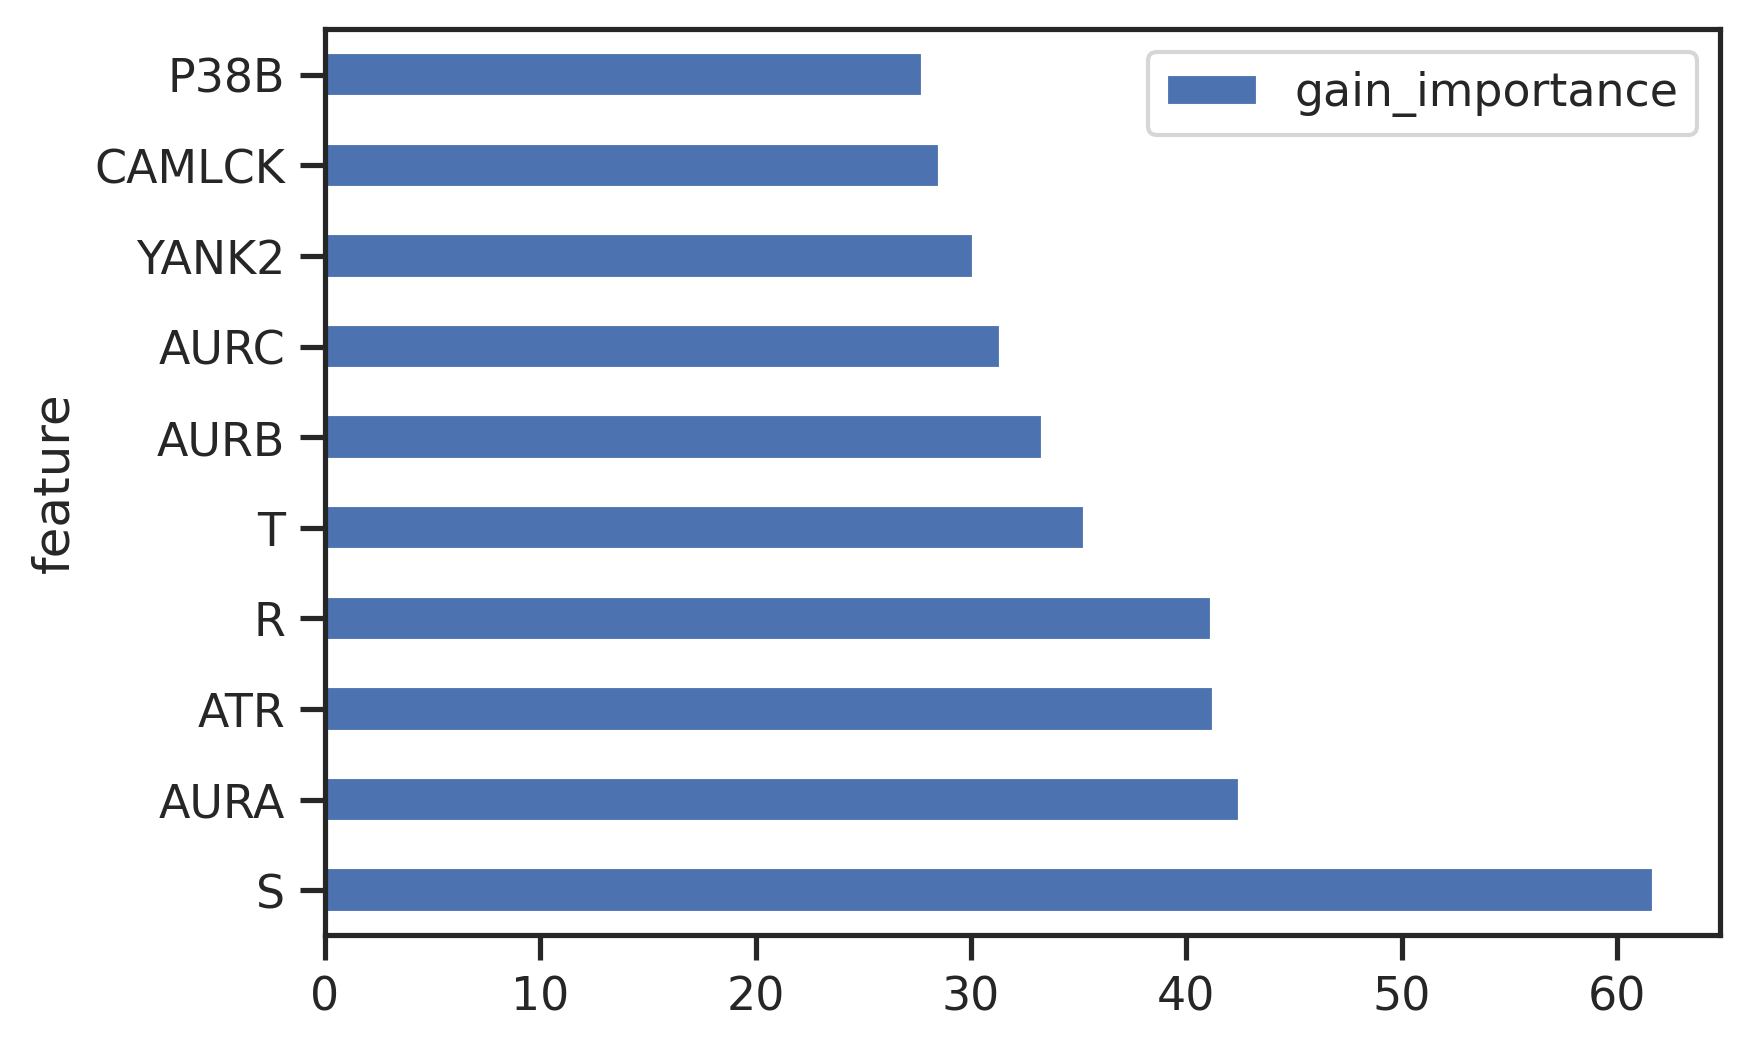

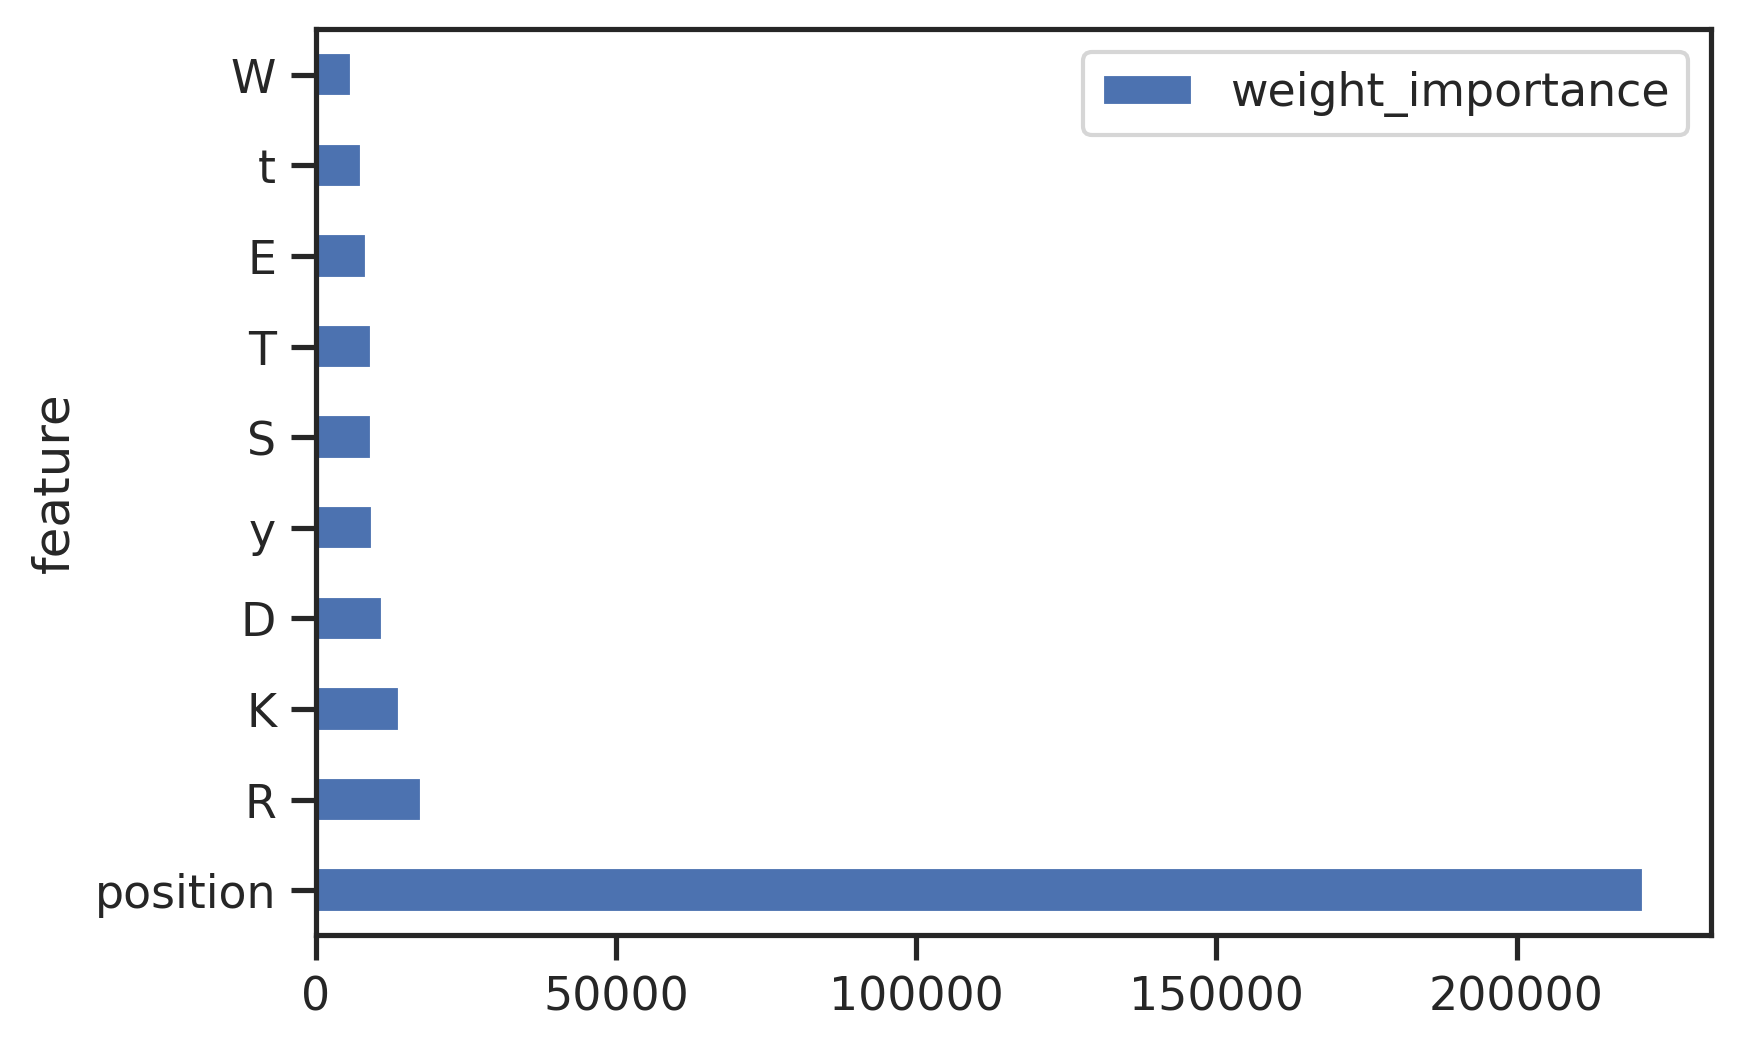

In [ ]:
FOLDS=5
pred_dfs = []
gains = []
weights = []
for fold, (train_idx, valid_idx) in enumerate(StratifiedGroupKFold(FOLDS).split(df2.index.values, df2.category,df2.kinase)):
    pred_df, gain, weight = xgb_trainer(df, feat_col, target_col = 'target', test_index=valid_idx, model_file = f'model/fold{fold}.bin')
    pred_dfs.append(pred_df)
    gains.append(gain)
    weights.append(weight)
    break

xgb params is: {'max_depth': 7, 'learning_rate': 0.001, 'subsample': 0.8, 'colsample_bytree': 1, 'eval_metric': 'rmse', 'objective': 'reg:squarederror', 'tree_method': 'gpu_hist', 'predictor': 'gpu_predictor', 'random_state': 123}
(47124, 38) (47124,) (11880, 38) (11880,)
Int64Index([  396,   397,   398,   399,   400,   401,   402,   403,   404,
              405,
            ...
            58004, 58005, 58006, 58007, 58008, 58009, 58010, 58011, 58012,
            58013],
           dtype='int64', length=11880)
[0]	train-rmse:1.09019	valid-rmse:1.19967
[100]	train-rmse:1.04661	valid-rmse:1.16338
[200]	train-rmse:1.00888	valid-rmse:1.13234
[300]	train-rmse:0.97609	valid-rmse:1.10599
[400]	train-rmse:0.94770	valid-rmse:1.08364
[500]	train-rmse:0.92299	valid-rmse:1.06462
[600]	train-rmse:0.90156	valid-rmse:1.04776
[700]	train-rmse:0.88273	valid-rmse:1.03328
[800]	train-rmse:0.86620	valid-rmse:1.02090
[900]	train-rmse:0.85169	valid-rmse:1.01018
[1000]	train-rmse:0.83891	valid-rmse:1.00068

xgb params is: {'max_depth': 7, 'learning_rate': 0.001, 'subsample': 0.8, 'colsample_bytree': 1, 'eval_metric': 'rmse', 'objective': 'reg:squarederror', 'tree_method': 'gpu_hist', 'predictor': 'gpu_predictor', 'random_state': 123}
(47124, 38) (47124,) (11880, 38) (11880,)
Int64Index([  990,   991,   992,   993,   994,   995,   996,   997,   998,
              999,
            ...
            58796, 58797, 58798, 58799, 58800, 58801, 58802, 58803, 58804,
            58805],
           dtype='int64', length=11880)
[0]	train-rmse:1.11201	valid-rmse:1.11728
[100]	train-rmse:1.06738	valid-rmse:1.08122
[200]	train-rmse:1.02876	valid-rmse:1.05086
[300]	train-rmse:0.99503	valid-rmse:1.02492
[400]	train-rmse:0.96589	valid-rmse:1.00330
[500]	train-rmse:0.94033	valid-rmse:0.98480
[600]	train-rmse:0.91798	valid-rmse:0.96924
[700]	train-rmse:0.89844	valid-rmse:0.95625
[800]	train-rmse:0.88146	valid-rmse:0.94532
[900]	train-rmse:0.86634	valid-rmse:0.93594
[1000]	train-rmse:0.85298	valid-rmse:0.92796

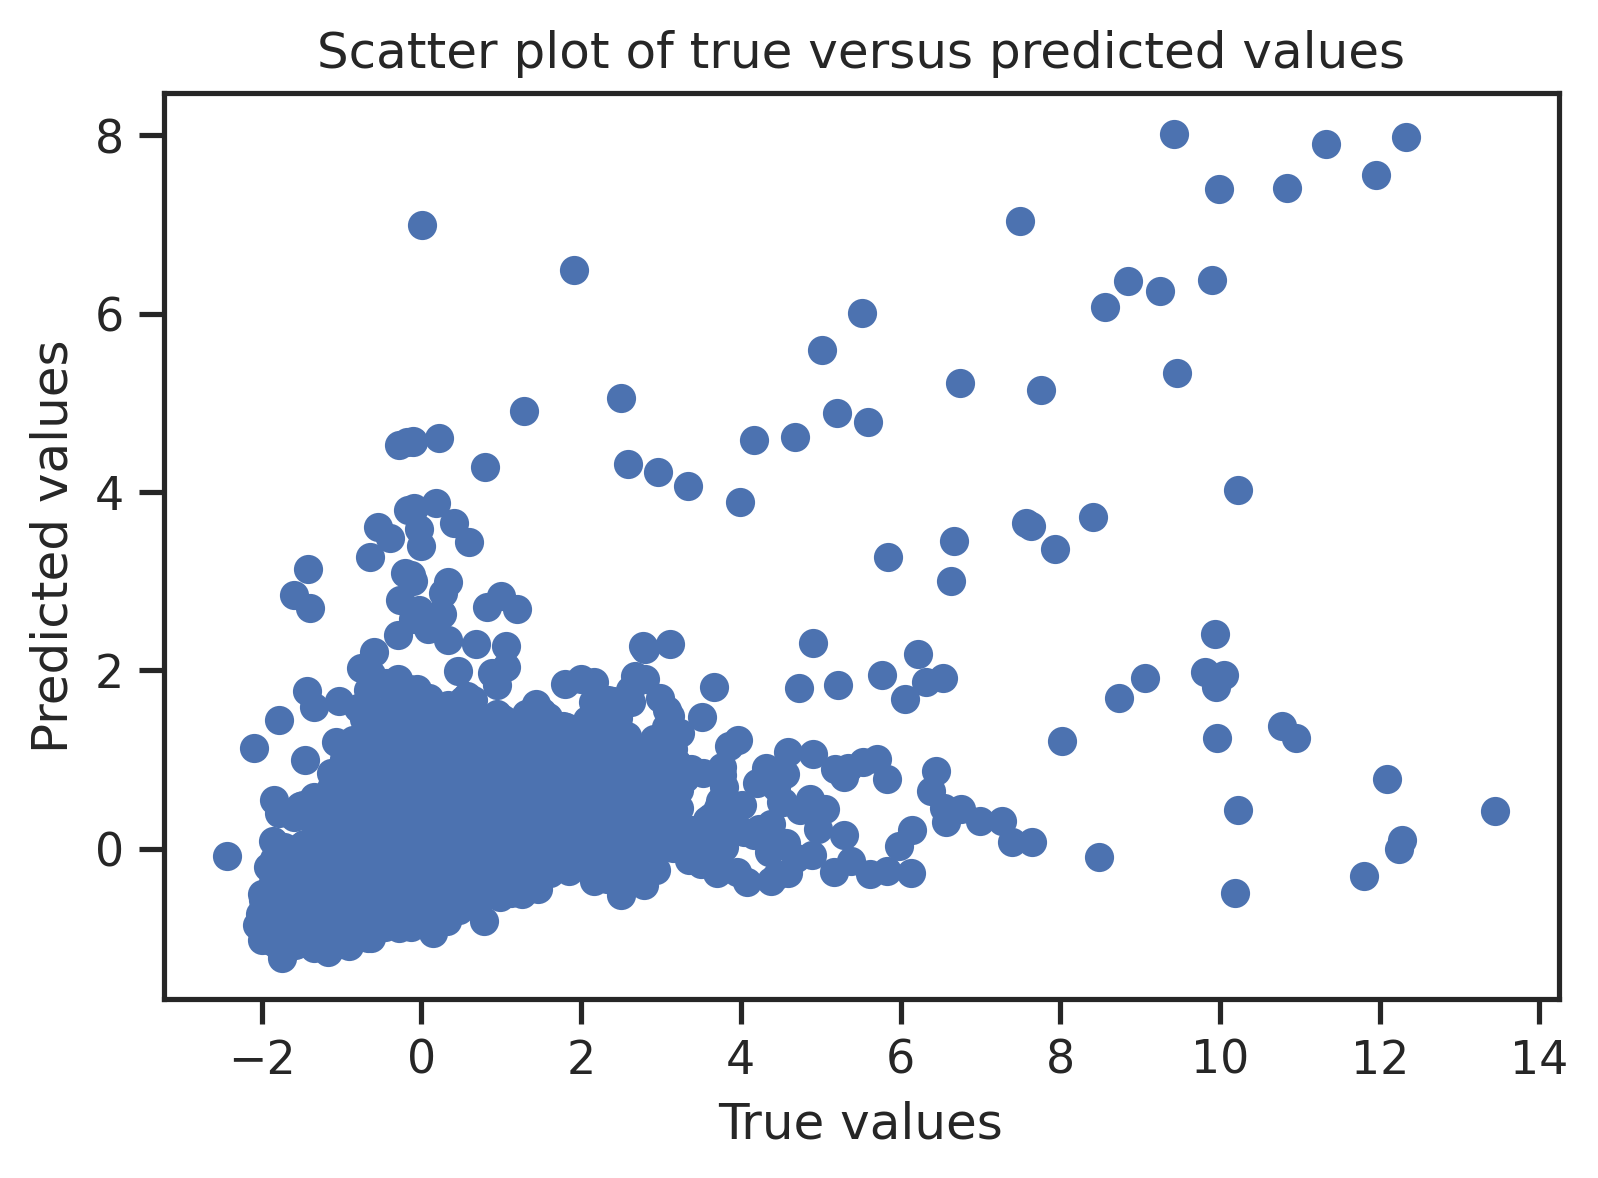

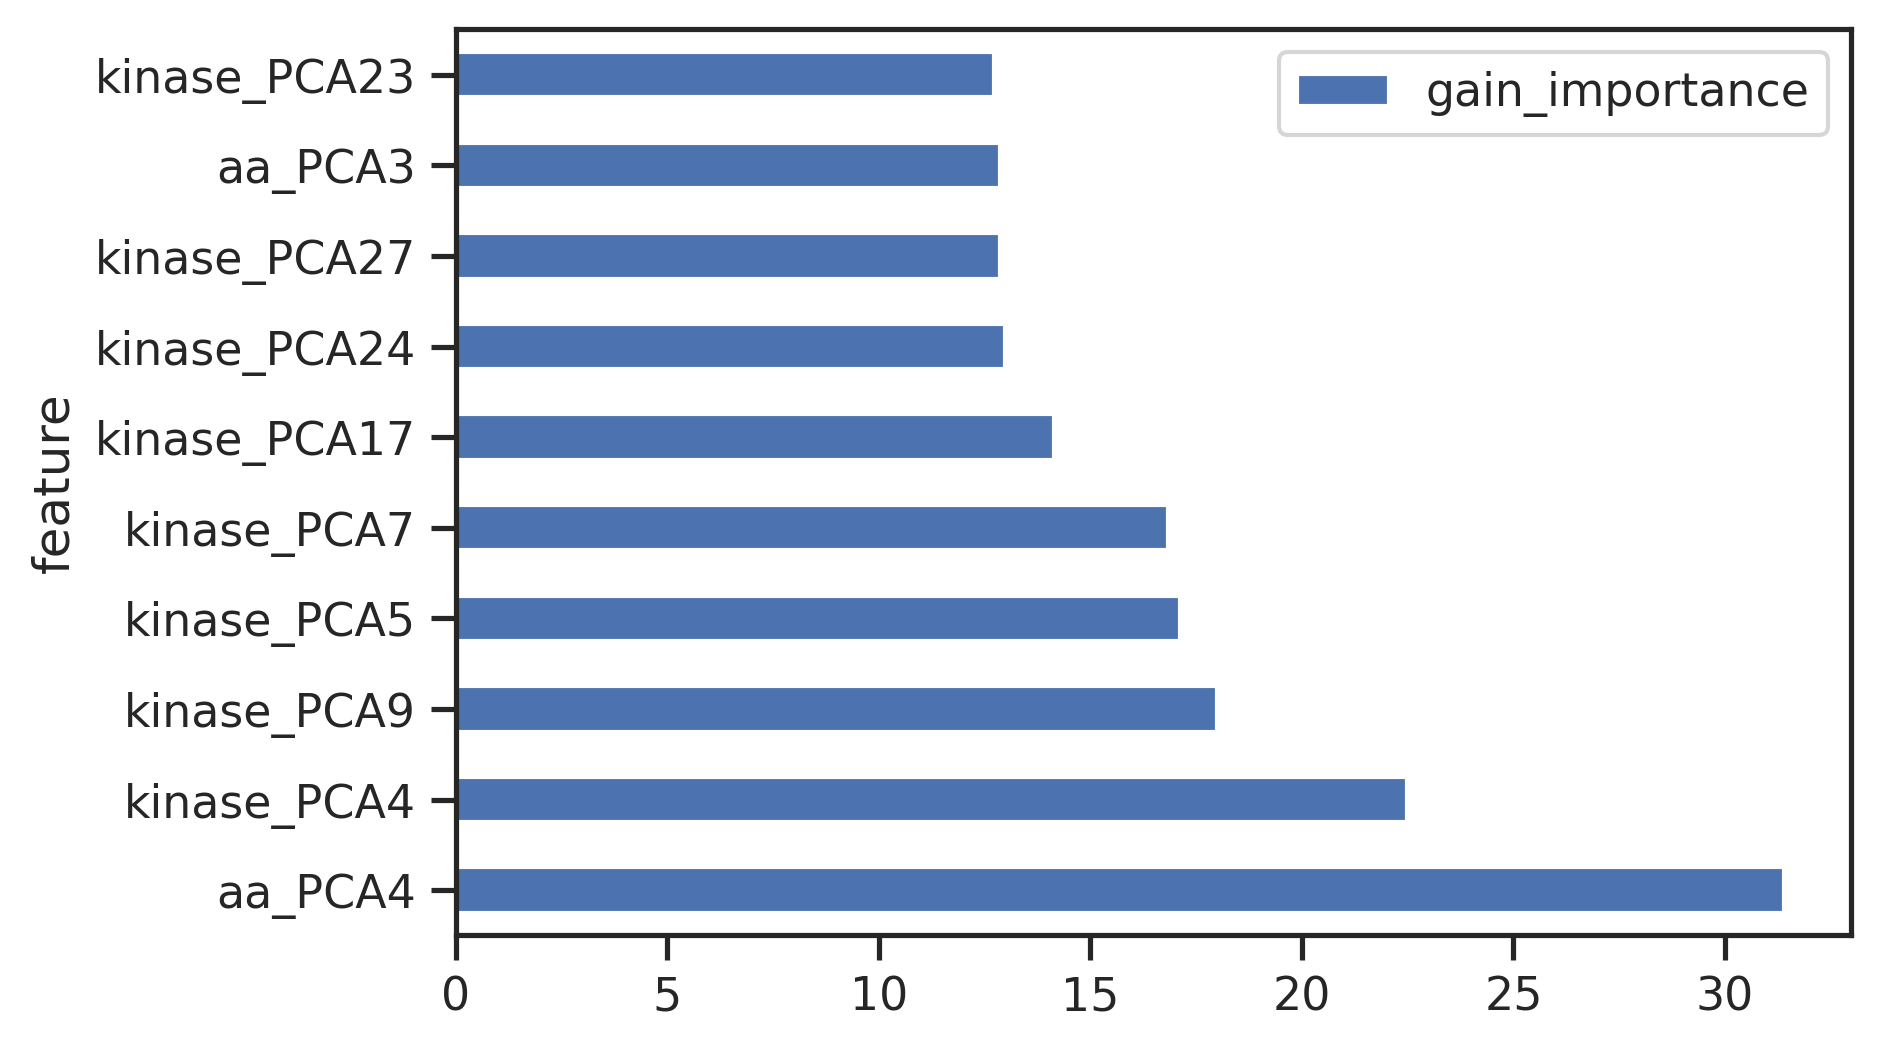

xgb params is: {'max_depth': 7, 'learning_rate': 0.001, 'subsample': 0.8, 'colsample_bytree': 1, 'eval_metric': 'rmse', 'objective': 'reg:squarederror', 'tree_method': 'gpu_hist', 'predictor': 'gpu_predictor', 'random_state': 123}
(47322, 38) (47322,) (11682, 38) (11682,)
Int64Index([ 1386,  1387,  1388,  1389,  1390,  1391,  1392,  1393,  1394,
             1395,
            ...
            58598, 58599, 58600, 58601, 58602, 58603, 58604, 58605, 58606,
            58607],
           dtype='int64', length=11682)
[0]	train-rmse:1.13284	valid-rmse:1.02907
[100]	train-rmse:1.08782	valid-rmse:0.99345
[200]	train-rmse:1.04870	valid-rmse:0.96359
[300]	train-rmse:1.01472	valid-rmse:0.93869
[400]	train-rmse:0.98519	valid-rmse:0.91751
[500]	train-rmse:0.95955	valid-rmse:0.90001
[600]	train-rmse:0.93734	valid-rmse:0.88530
[700]	train-rmse:0.91796	valid-rmse:0.87295
[800]	train-rmse:0.90102	valid-rmse:0.86209
[900]	train-rmse:0.88581	valid-rmse:0.85261
[1000]	train-rmse:0.87217	valid-rmse:0.84397

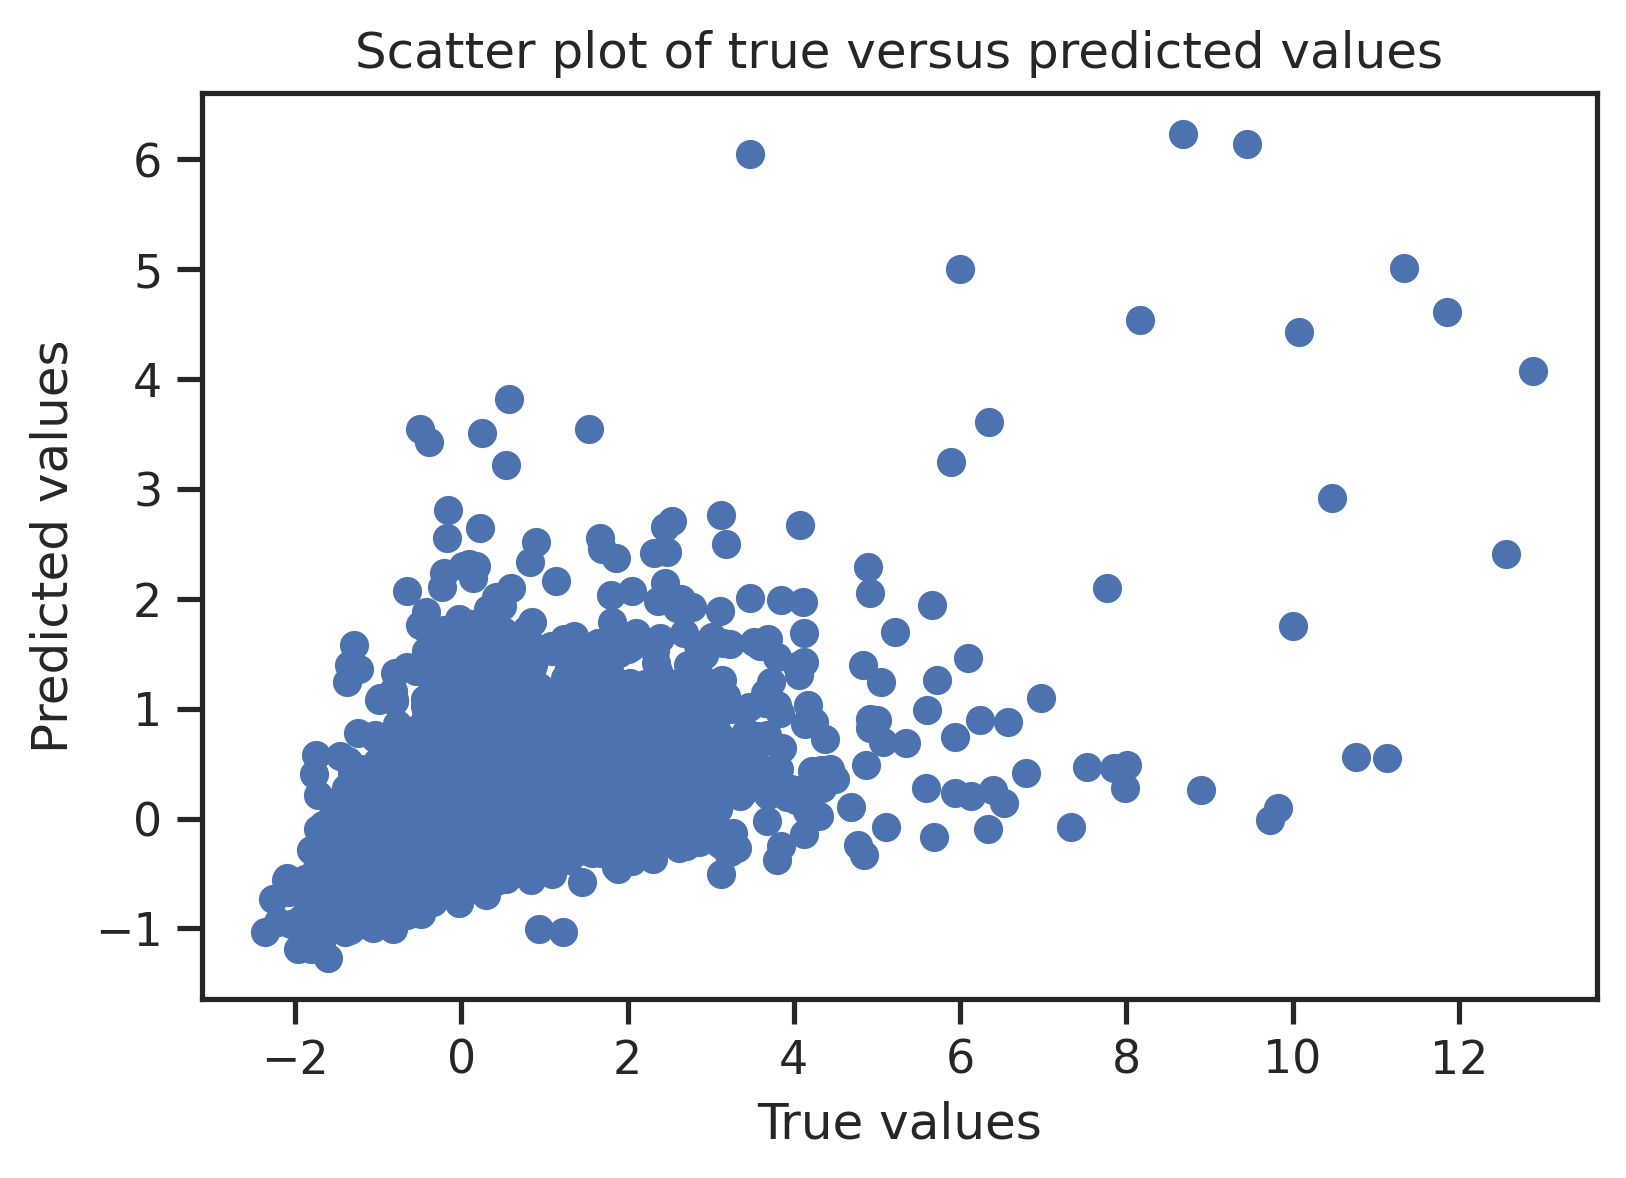

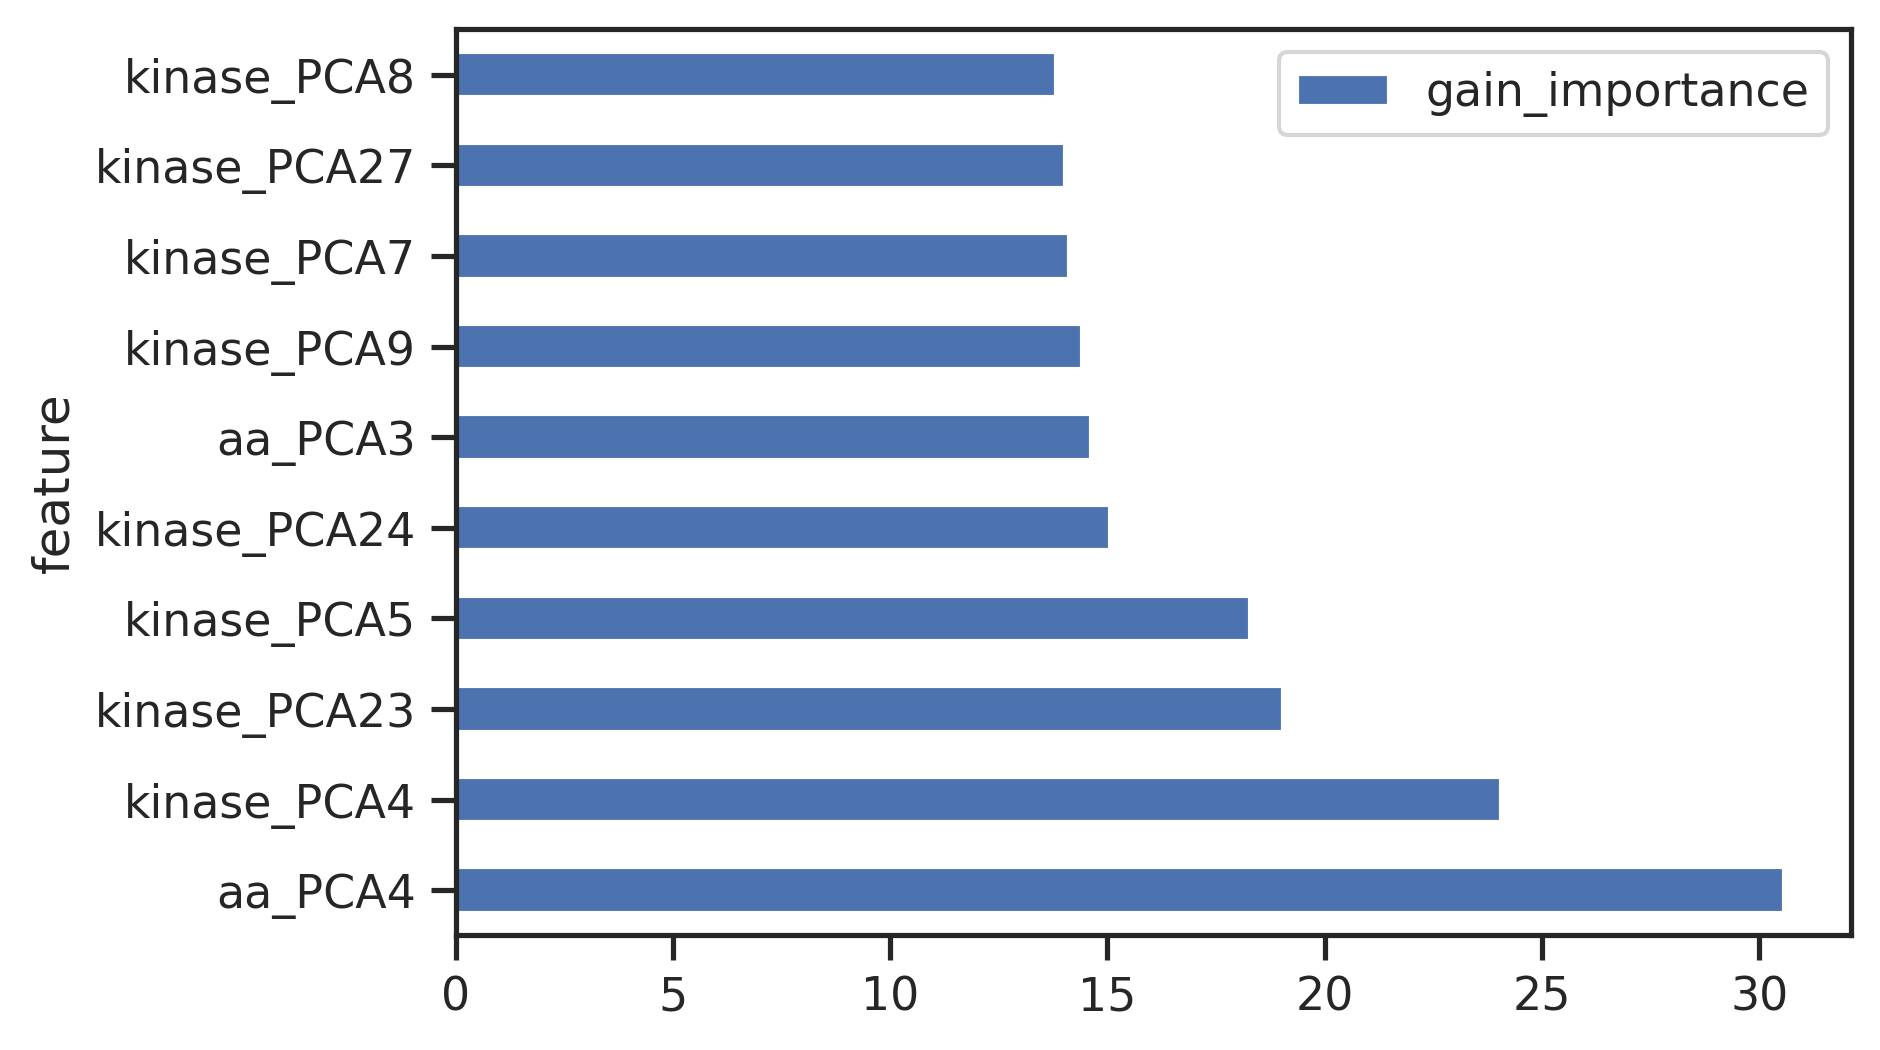

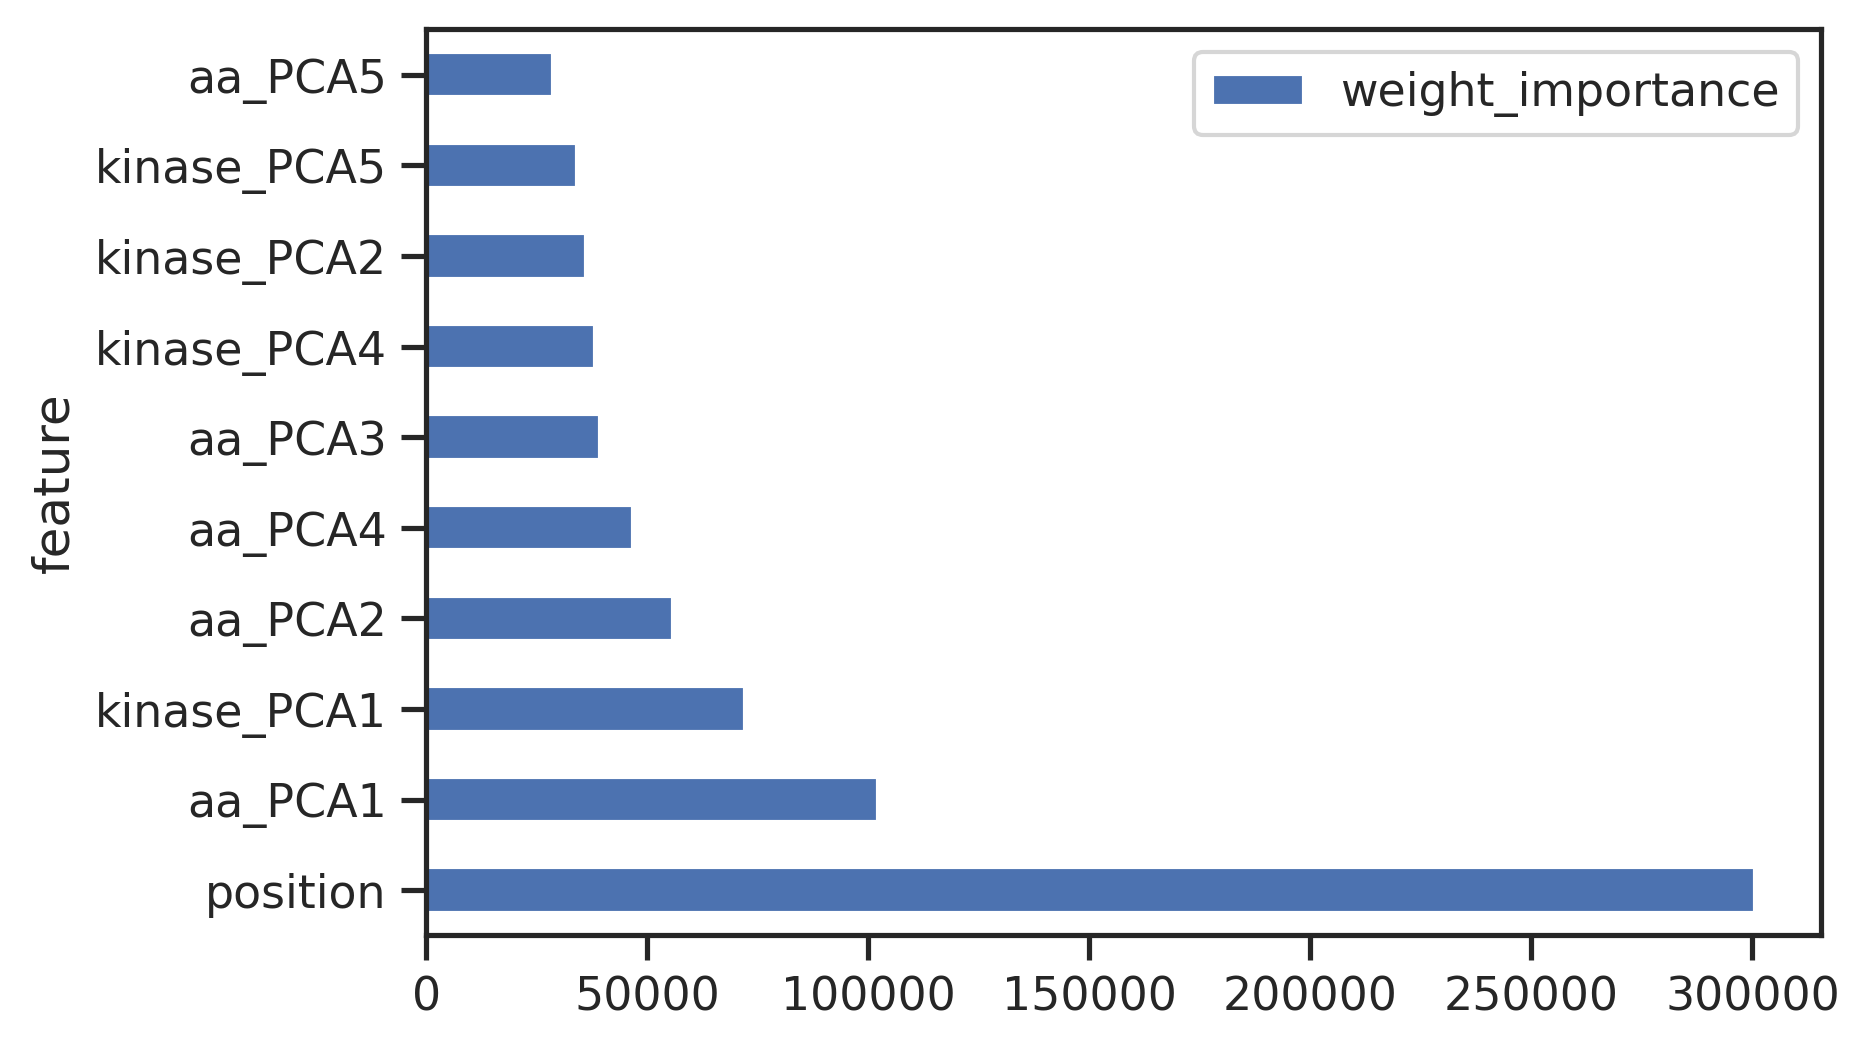

xgb params is: {'max_depth': 7, 'learning_rate': 0.001, 'subsample': 0.8, 'colsample_bytree': 1, 'eval_metric': 'rmse', 'objective': 'reg:squarederror', 'tree_method': 'gpu_hist', 'predictor': 'gpu_predictor', 'random_state': 123}
(47322, 38) (47322,) (11682, 38) (11682,)
Int64Index([    0,     1,     2,     3,     4,     5,     6,     7,     8,
                9,
            ...
            58994, 58995, 58996, 58997, 58998, 58999, 59000, 59001, 59002,
            59003],
           dtype='int64', length=11682)
[0]	train-rmse:1.11732	valid-rmse:1.09569
[100]	train-rmse:1.07230	valid-rmse:1.05686
[200]	train-rmse:1.03323	valid-rmse:1.02451
[300]	train-rmse:0.99937	valid-rmse:0.99774
[400]	train-rmse:0.96987	valid-rmse:0.97545
[500]	train-rmse:0.94429	valid-rmse:0.95690
[600]	train-rmse:0.92194	valid-rmse:0.94184
[700]	train-rmse:0.90250	valid-rmse:0.92931
[800]	train-rmse:0.88548	valid-rmse:0.91892
[900]	train-rmse:0.87046	valid-rmse:0.91018
[1000]	train-rmse:0.85724	valid-rmse:0.90287

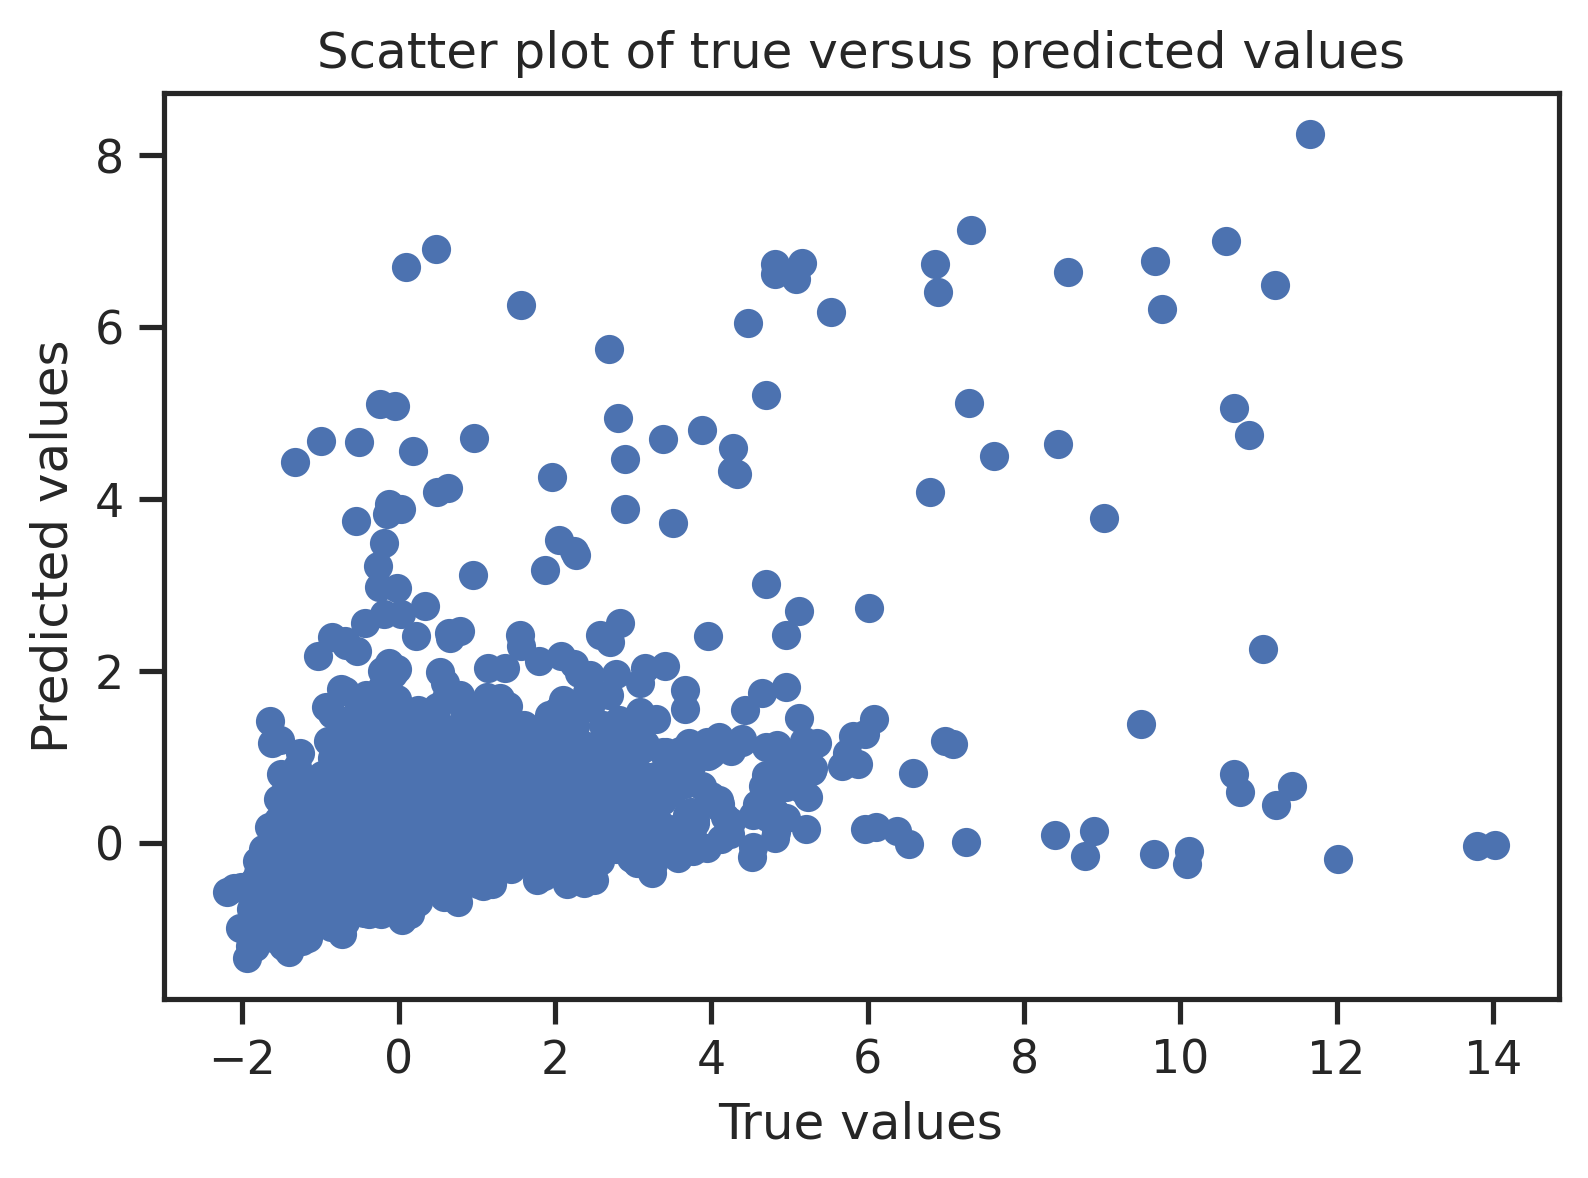

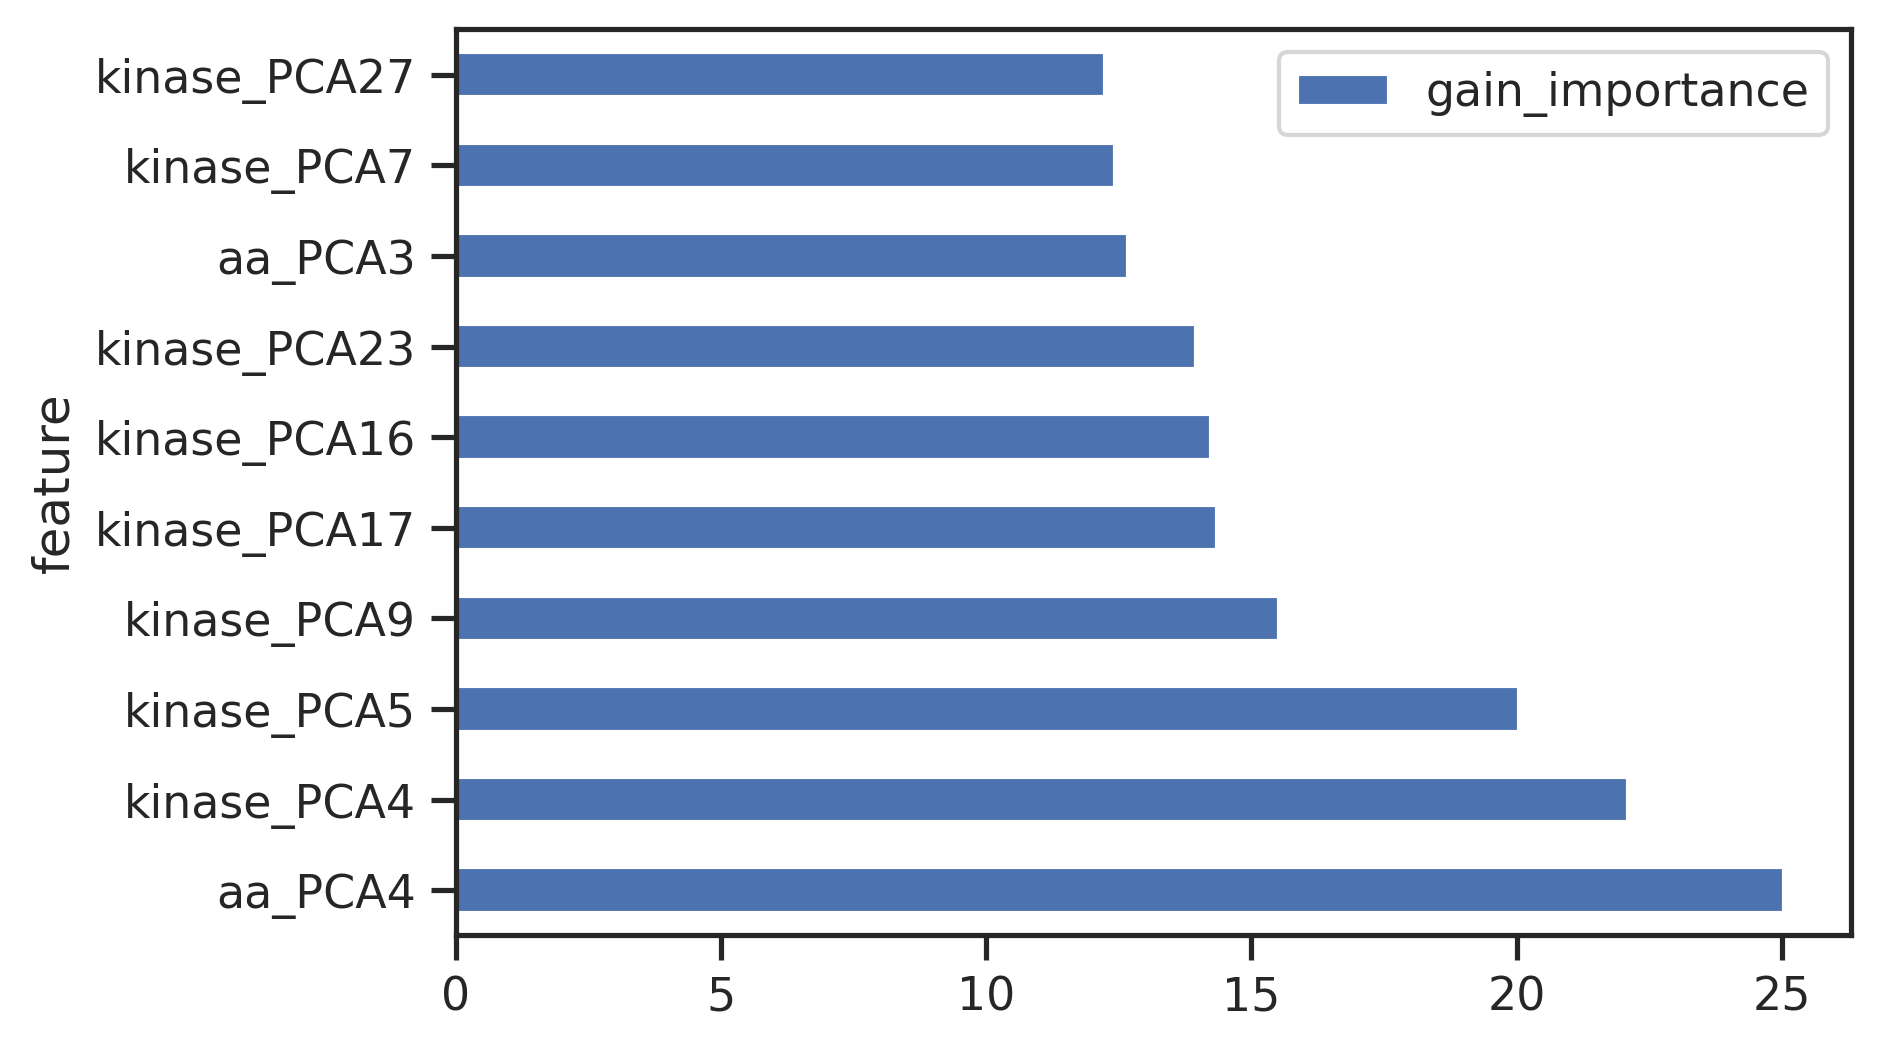

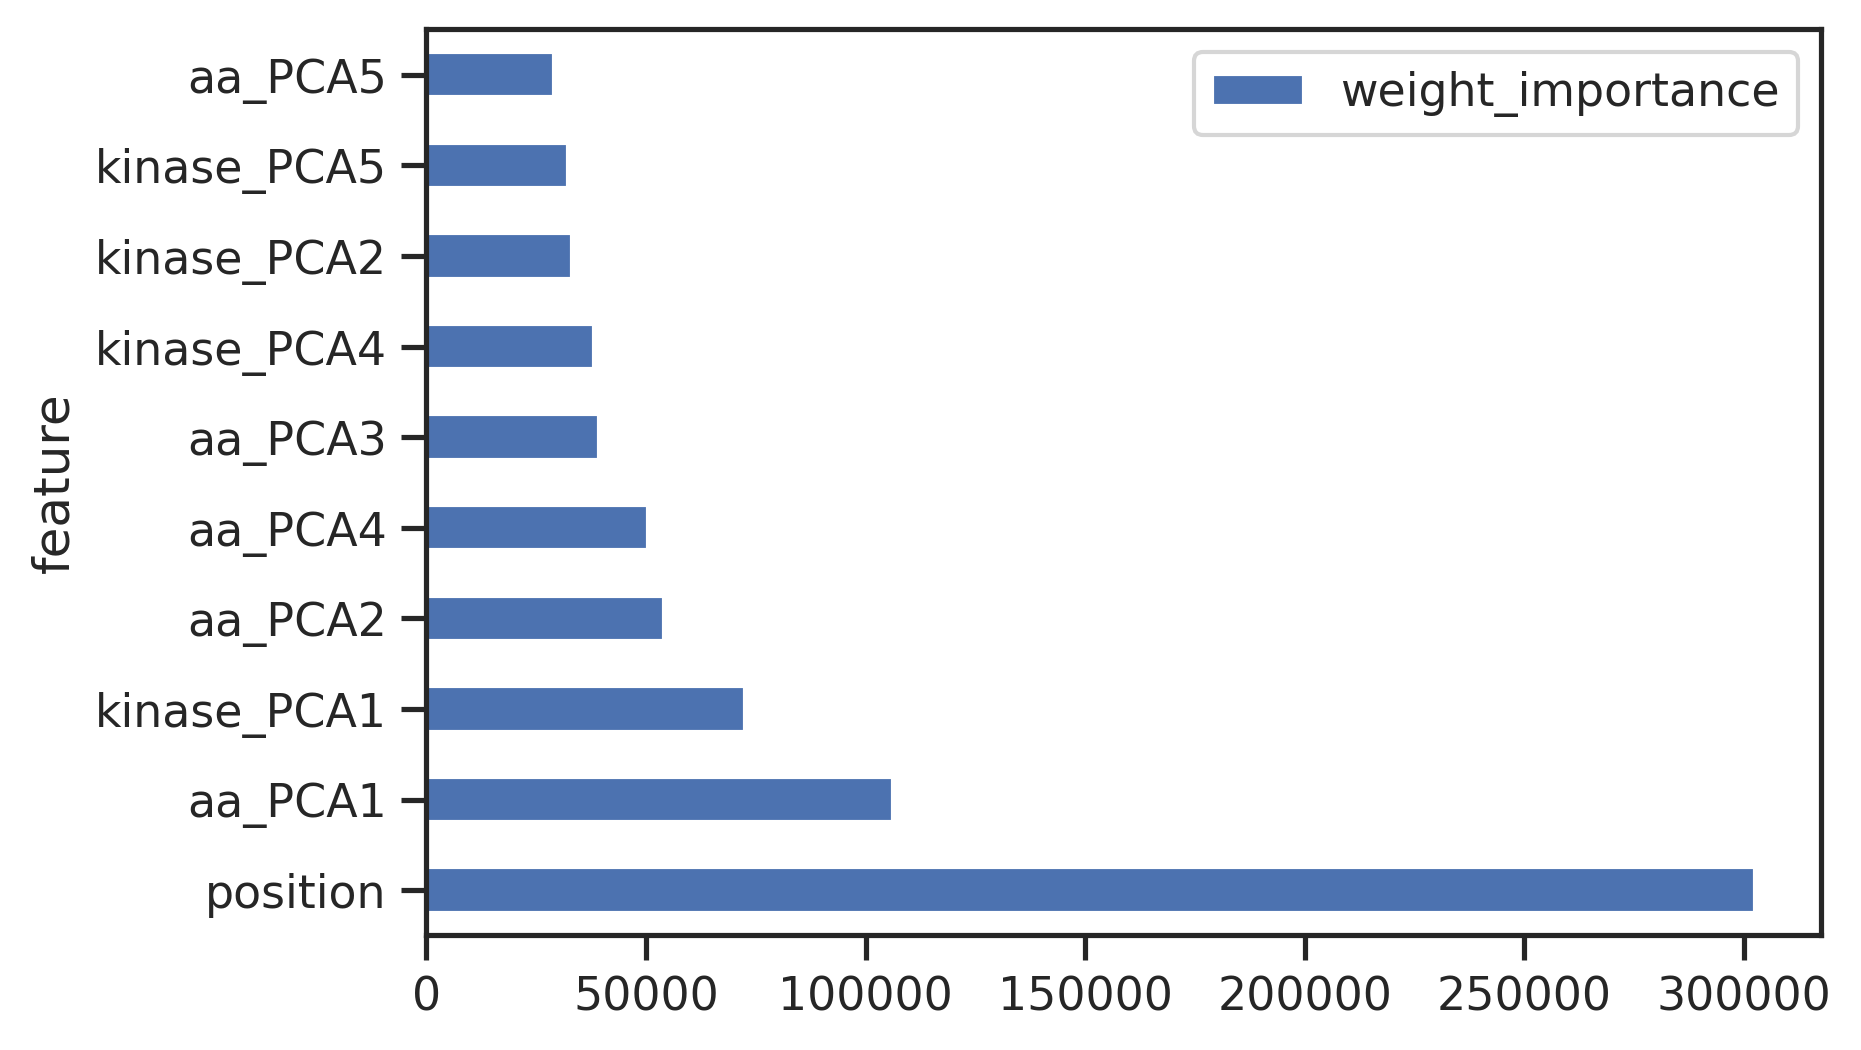

xgb params is: {'max_depth': 7, 'learning_rate': 0.001, 'subsample': 0.8, 'colsample_bytree': 1, 'eval_metric': 'rmse', 'objective': 'reg:squarederror', 'tree_method': 'gpu_hist', 'predictor': 'gpu_predictor', 'random_state': 123}
(47124, 38) (47124,) (11880, 38) (11880,)
Int64Index([  198,   199,   200,   201,   202,   203,   204,   205,   206,
              207,
            ...
            57806, 57807, 57808, 57809, 57810, 57811, 57812, 57813, 57814,
            57815],
           dtype='int64', length=11880)
[0]	train-rmse:1.11242	valid-rmse:1.11563
[100]	train-rmse:1.06862	valid-rmse:1.07390
[200]	train-rmse:1.03042	valid-rmse:1.03864
[300]	train-rmse:0.99681	valid-rmse:1.00926
[400]	train-rmse:0.96750	valid-rmse:0.98482
[500]	train-rmse:0.94212	valid-rmse:0.96436
[600]	train-rmse:0.92001	valid-rmse:0.94708
[700]	train-rmse:0.90075	valid-rmse:0.93258
[800]	train-rmse:0.88377	valid-rmse:0.92028
[900]	train-rmse:0.86871	valid-rmse:0.90969
[1000]	train-rmse:0.85510	valid-rmse:0.90027

In [ ]:
FOLDS=5
pred_dfs = []
gains = []
weights = []
for fold, (train_idx, valid_idx) in enumerate(StratifiedGroupKFold(FOLDS).split(df2.index.values, df2.category,df2.kinase)):
    pred_df, gain, weight = xgb_trainer(df, feat_col, target_col = 'target', test_index=valid_idx, model_file = f'model/fold{fold}.bin')
    pred_dfs.append(pred_df)
    gains.append(gain)
    weights.append(weight)

Save gain importance and weight importance of each fold to dataframes

In [ ]:
# gain importance
g = pd.concat(gains, axis=1, keys=range(len(gains)))

g.columns = ['gain_importance_'+ str(i) for i in range(FOLDS)]

In [ ]:
# weight importance
w = pd.concat(weights,axis=1,keys = range(len(weights)))

w.columns = ['weight_importance_'+ str(i) for i in range(FOLDS)]

In [ ]:
# g.to_csv('model/gains.csv')
# w.to_csv('model/weights.csv')

In [ ]:
g.head()

In [ ]:
w.head()